In [1]:
import sys
from pathlib import Path


# Get the project root directory
root_dir = Path().resolve()
if root_dir.name == 'your_project':
    sys.path.append(str(root_dir))
else:
    # If notebook is in a subdirectory
    parent_dir = root_dir.parent
    sys.path.append(str(parent_dir))



import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix
from modules.data.raw_data_handler import RawDataHandler
import datetime
import json

log_messages = []

def log(msg):
    """
    logs the message to the console
    AND stores it in the log_messages list for later use in the response.
    """
    print(msg)
    log_messages.append(msg)


In [2]:
dataset_dir = os.path.join( "storage", "merged_data.csv")

# Define the path to your CSV file (adjust the path as needed)
csv_file_path = dataset_dir

# Read the CSV file into a DataFrame named cleaned_data
cleaned_data = pd.read_csv(csv_file_path)

# Verify that the target column "fraud_label" exists
if "fraud_label" not in cleaned_data.columns:
    raise ValueError("The CSV file does not contain the required 'fraud_label' column.")

# Optionally, separate features and target:
X = cleaned_data.drop("fraud_label", axis=1)
y = cleaned_data["fraud_label"]

log("Dataset loaded successfully!")
log("Total records:")
log(cleaned_data.shape[0])
log("Total features:")
log(X.shape[1])

# log the remaining columns after dropping
log("Remaining columns in the dataset:")
log(list(cleaned_data.columns))

Dataset loaded successfully!
Total records:
1081015
Total features:
30
Remaining columns in the dataset:
['trans_num', 'index_x', 'trans_date_trans_time', 'cc_num', 'unix_time', 'merchant', 'category', 'amt', 'merch_lat', 'merch_long', 'fraud_label', 'index_y', 'first', 'last', 'sex', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'day_of_week', 'hour', 'minute', 'second', 'day_date', 'month_date', 'year_date']


In [3]:

columns_to_drop = [
   'trans_num', 'index_x', 'trans_date_trans_time', 'merch_lat', 'merch_long', 'index_y', 'first', 'last', 'sex', 'street', 'city', 'lat', 'long', 'dob', 'year_date']
# Drop the columns
cleaned_data = cleaned_data.drop(columns=columns_to_drop)

# Verify the columns were dropped
print(cleaned_data.columns)

Index(['cc_num', 'unix_time', 'merchant', 'category', 'amt', 'fraud_label',
       'state', 'zip', 'city_pop', 'job', 'day_of_week', 'hour', 'minute',
       'second', 'day_date', 'month_date'],
      dtype='object')


In [4]:
# Get a summary of your data
print(cleaned_data.info())

# Check the first few rows to see potential missing value patterns
print(cleaned_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081015 entries, 0 to 1081014
Data columns (total 16 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   cc_num       1081015 non-null  int64  
 1   unix_time    1081015 non-null  float64
 2   merchant     1081015 non-null  object 
 3   category     1081015 non-null  object 
 4   amt          1081015 non-null  float64
 5   fraud_label  1081015 non-null  float64
 6   state        1081015 non-null  object 
 7   zip          1081015 non-null  float64
 8   city_pop     1081015 non-null  float64
 9   job          1081015 non-null  object 
 10  day_of_week  1081015 non-null  object 
 11  hour         1081015 non-null  int64  
 12  minute       1081015 non-null  int64  
 13  second       1081015 non-null  int64  
 14  day_date     1081015 non-null  int64  
 15  month_date   1081015 non-null  object 
dtypes: float64(5), int64(5), object(6)
memory usage: 132.0+ MB
None
             cc_num     un

In [5]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
columns_to_encode = ['merchant', 'category', 'state', 'job', 'day_of_week', 'month_date']

# Create a dictionary to store the encoders
label_encoders = {}

# Create a copy of the dataframe to avoid modifying the original
encoded_data = cleaned_data.copy()

# Apply label encoding to each column
for column in columns_to_encode:
    le = LabelEncoder()
    encoded_data[column] = le.fit_transform(encoded_data[column])
    
    # Store the encoder for future reference (optional)
    label_encoders[column] = le
    
    # Print mapping information (optional)
    print(f"Encoded {column}: {len(le.classes_)} unique values")

# Verify the encoding worked
print("\nSample of encoded data:")
print(encoded_data[columns_to_encode].head())

Encoded merchant: 693 unique values
Encoded category: 28 unique values
Encoded state: 50 unique values
Encoded job: 563 unique values
Encoded day_of_week: 7 unique values
Encoded month_date: 12 unique values

Sample of encoded data:
   merchant  category  state  job  day_of_week  month_date
0       684        10      8  362            3           2
1       472        18     21  253            2           4
2       686         1     37  473            1           2
3       395         4      2   58            0           1
4       574         0     23  526            2           7


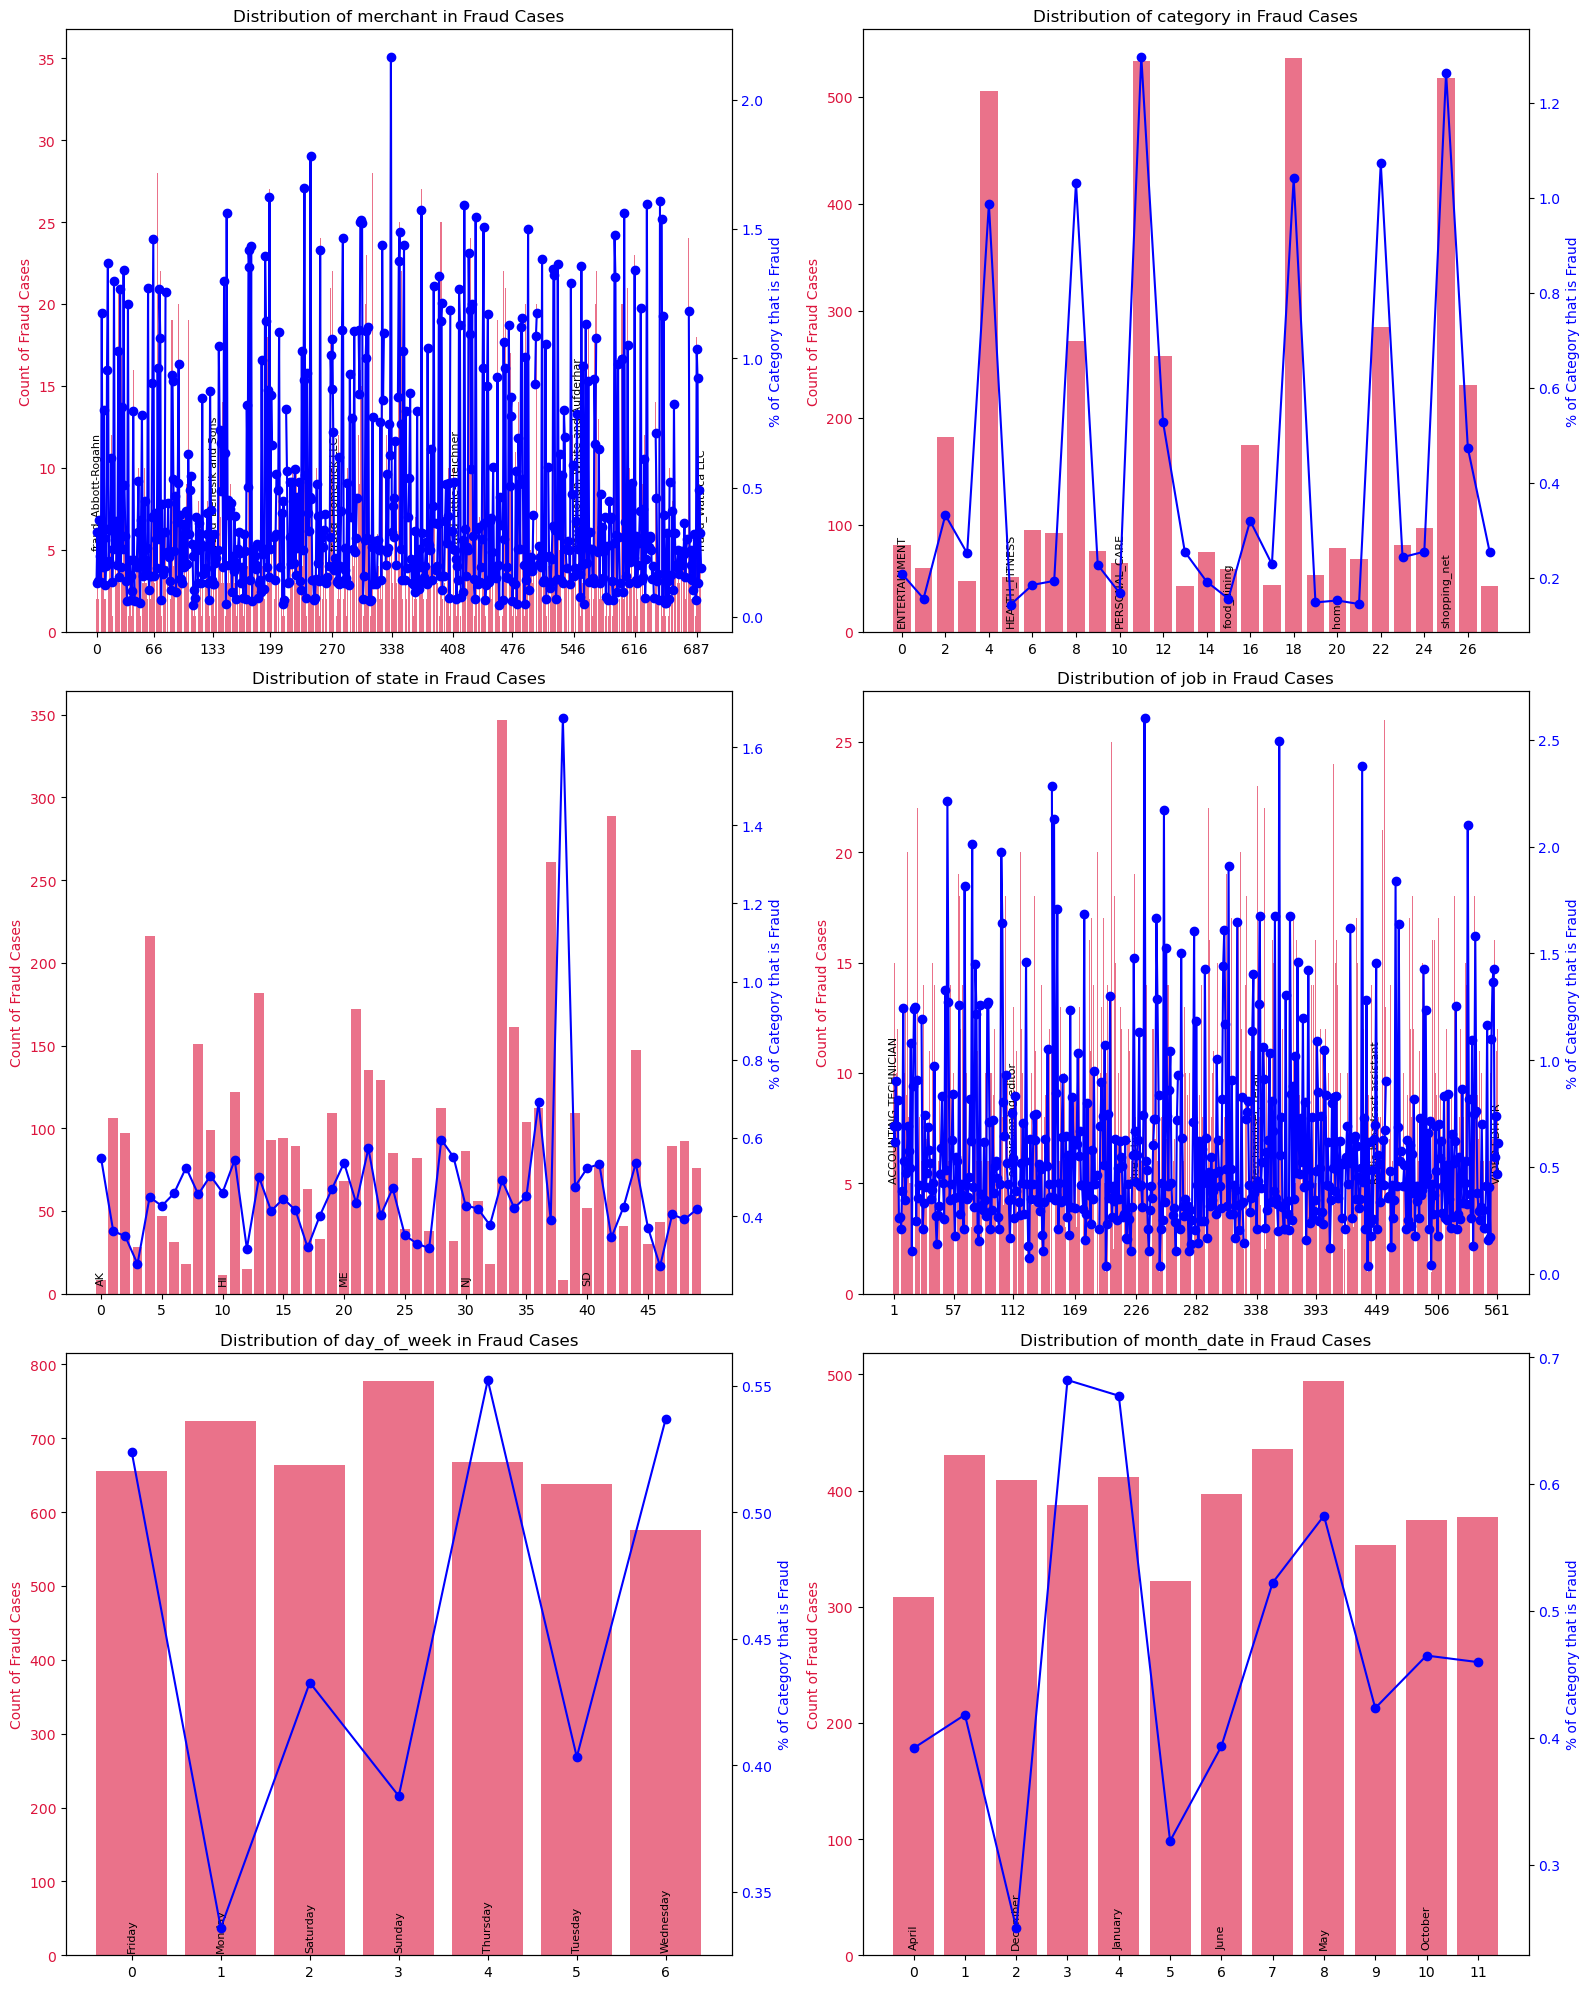

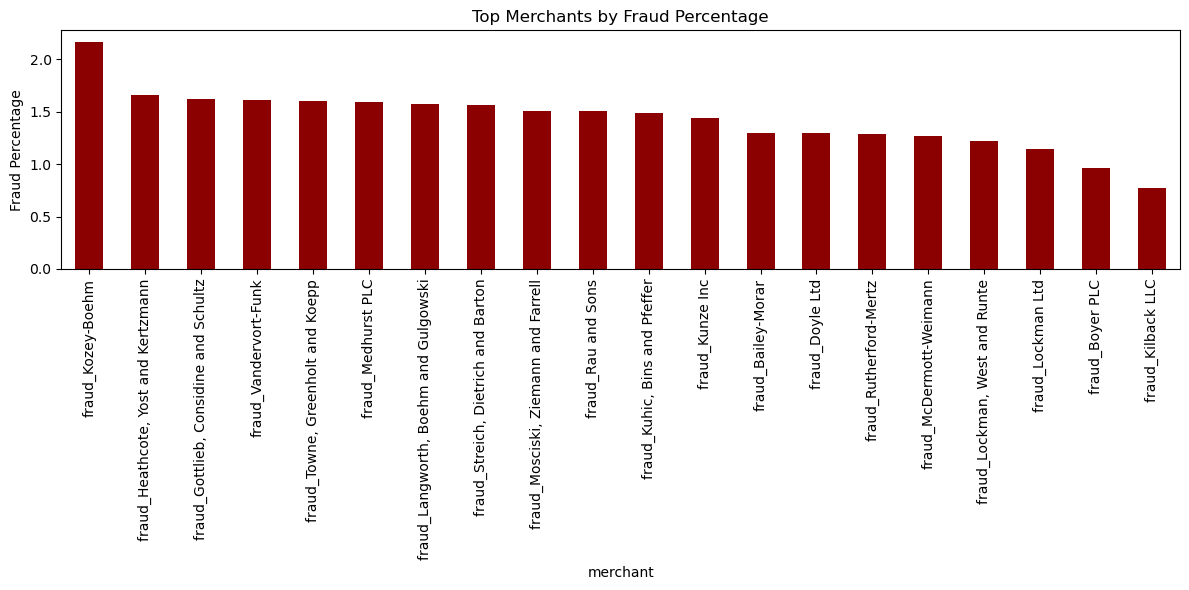

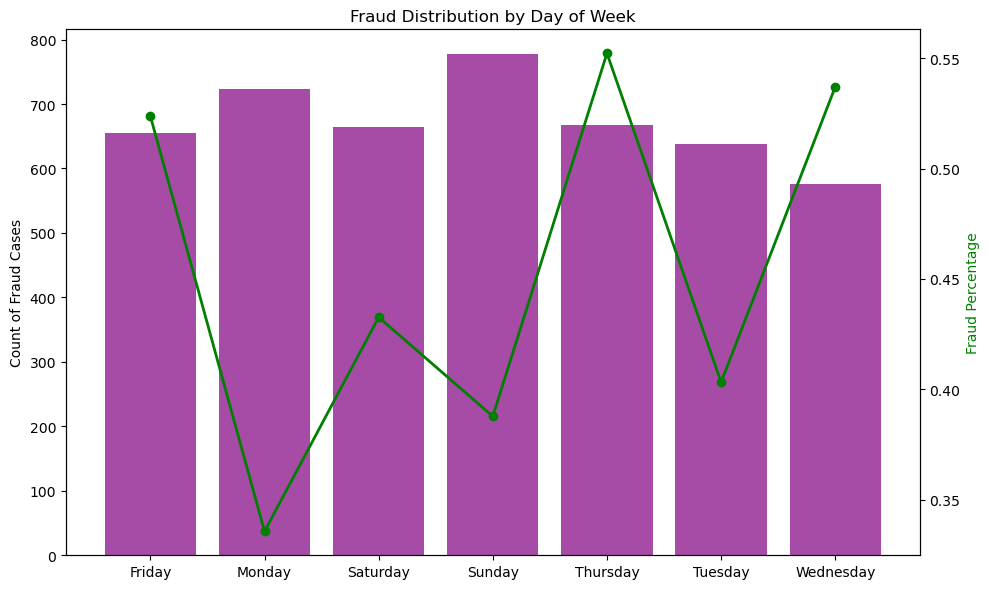

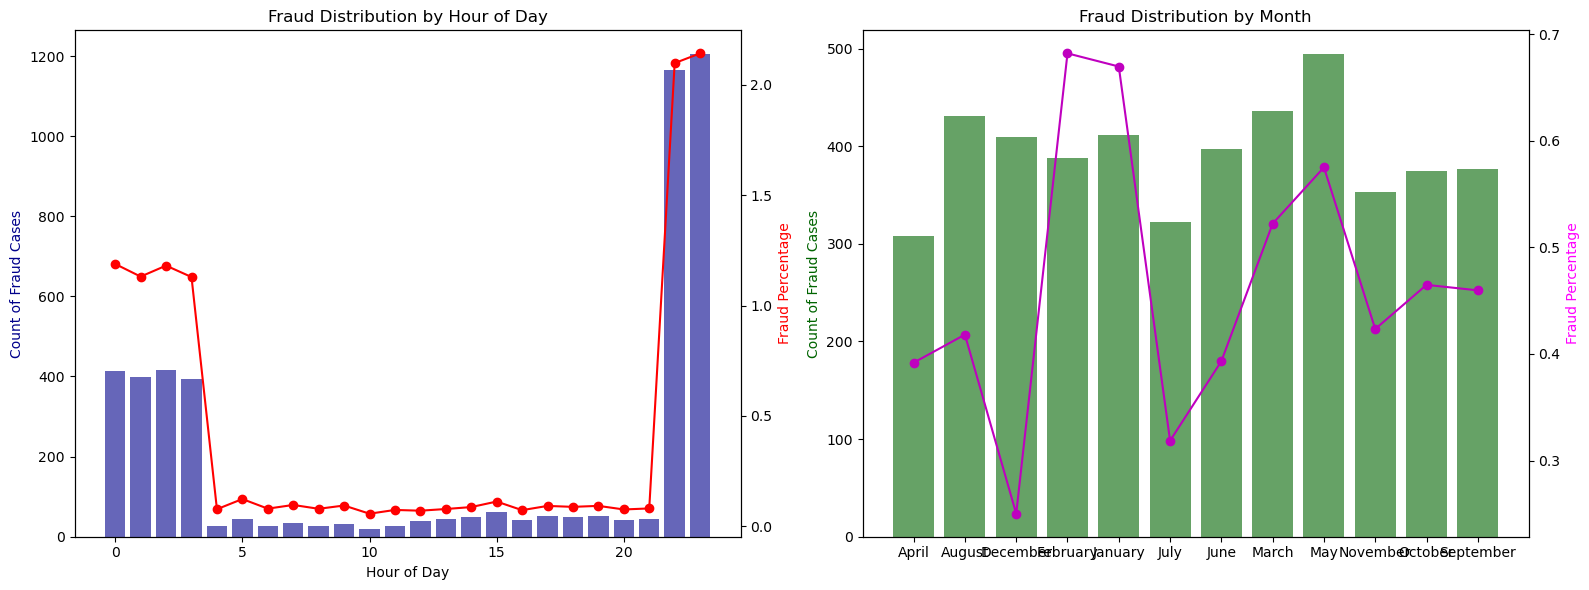

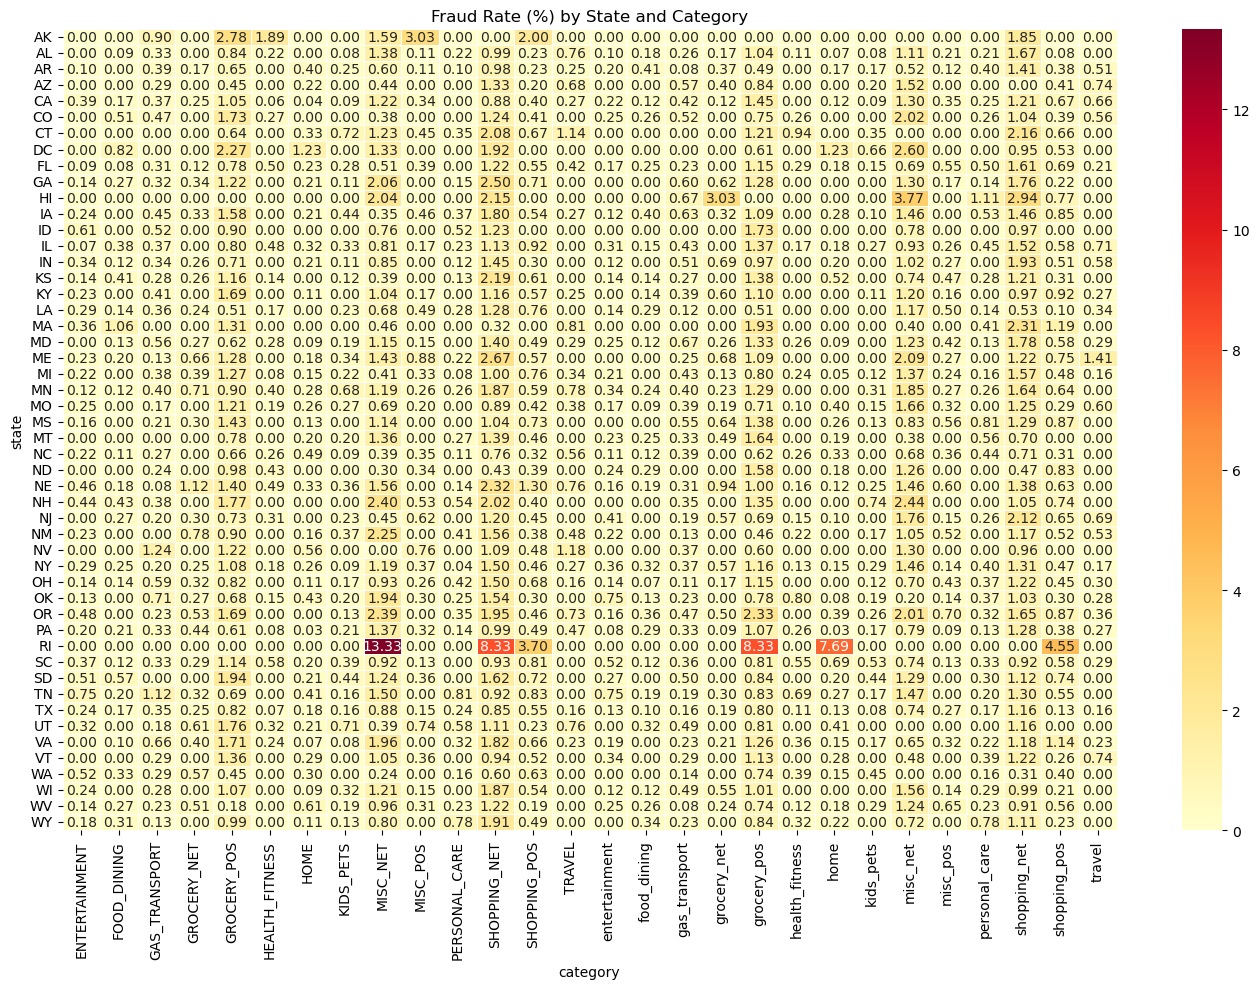

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have already created encoded_data with 'fraud_label' column
# If 'fraud_label' was dropped earlier, make sure you have it in your dataframe

# Filter for fraud cases
fraud_data = encoded_data[encoded_data['fraud_label'] == 1]
non_fraud_data = encoded_data[encoded_data['fraud_label'] == 0]

# Set up the plots
plt.figure(figsize=(16, 20))
columns_to_analyze = ['merchant', 'category', 'state', 'job', 'day_of_week', 'month_date']

# Plot distribution for each column
for i, column in enumerate(columns_to_analyze):
    plt.subplot(3, 2, i+1)
    
    # For categorical columns (the encoded ones)
    if column in columns_to_encode:
        # Count frequency of each category in fraud cases
        value_counts = fraud_data[column].value_counts().sort_index()
        
        # Get total counts for calculating percentages
        total_counts = encoded_data[column].value_counts().sort_index()
        fraud_percentage = (value_counts / total_counts) * 100
        
        # Plot both the raw count and the percentage
        ax1 = plt.gca()
        bars = ax1.bar(value_counts.index, value_counts.values, alpha=0.6, color='crimson')
        ax1.set_ylabel('Count of Fraud Cases', color='crimson')
        ax1.tick_params(axis='y', labelcolor='crimson')
        
        # Add percentage axis
        ax2 = ax1.twinx()
        line = ax2.plot(fraud_percentage.index, fraud_percentage.values, 'b-', marker='o')
        ax2.set_ylabel('% of Category that is Fraud', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        
        # If we have too many categories, limit x-axis labels
        if len(value_counts) > 10:
            plt.xticks(rotation=90)
            
            # Only show some of the labels to avoid overcrowding
            step = max(1, len(value_counts) // 10)
            plt.xticks(value_counts.index[::step])
        
        # Try to map back to original labels if available
        if column in label_encoders:
            # Create a mapping dictionary
            label_map = {i: label for i, label in enumerate(label_encoders[column].classes_)}
            
            # Add some labels for reference in the plot
            for j, bar in enumerate(bars):
                if j % max(1, len(bars) // 5) == 0:  # Add labels for every 5th bar
                    ax1.text(bar.get_x() + bar.get_width()/2, 5,
                            f"{label_map.get(j, j)}", 
                            ha='center', va='bottom', rotation=90, fontsize=8)
    
    # For numerical columns, use histograms
    else:
        sns.histplot(data=fraud_data, x=column, color='crimson', kde=True, alpha=0.6)
        
    plt.title(f'Distribution of {column} in Fraud Cases')
    plt.tight_layout()

# Add a plot for top fraud merchants if merchant is in the dataset
if 'merchant' in columns_to_analyze:
    plt.figure(figsize=(12, 6))
    top_fraud_merchants = fraud_data['merchant'].value_counts().head(20)
    
    # Calculate fraud percentage for these merchants
    merchant_counts = encoded_data['merchant'].value_counts()
    top_fraud_merchant_indexes = top_fraud_merchants.index
    top_merchant_total_counts = merchant_counts[top_fraud_merchant_indexes]
    fraud_percentage = (top_fraud_merchants / top_merchant_total_counts) * 100
    
    # Sort by percentage
    fraud_percentage = fraud_percentage.sort_values(ascending=False)
    
    # Create the bar plot
    ax = fraud_percentage.plot(kind='bar', color='darkred')
    
    # Try to map back to original merchant names
    if 'merchant' in label_encoders:
        label_map = {i: label for i, label in enumerate(label_encoders['merchant'].classes_)}
        labels = [label_map.get(idx, idx) for idx in fraud_percentage.index]
        ax.set_xticklabels(labels, rotation=90)
    
    plt.title('Top Merchants by Fraud Percentage')
    plt.ylabel('Fraud Percentage')
    plt.tight_layout()

# Plot fraud by day of week if available
if 'day_of_week' in columns_to_analyze:
    plt.figure(figsize=(10, 6))
    
    # Get the day of week distribution
    dow_fraud = fraud_data['day_of_week'].value_counts().reindex(range(7), fill_value=0)
    
    # Get total counts and calculate percentage
    dow_total = encoded_data['day_of_week'].value_counts().reindex(range(7), fill_value=0)
    dow_percentage = (dow_fraud / dow_total) * 100
    
    # Create a bar plot
    ax = plt.subplot(111)
    bars = ax.bar(dow_fraud.index, dow_fraud.values, alpha=0.7, color='purple')
    
    # Add percentage line
    ax2 = ax.twinx()
    line = ax2.plot(dow_percentage.index, dow_percentage.values, 'g-', marker='o', linewidth=2)
    ax2.set_ylabel('Fraud Percentage', color='green')
    
    # Map numeric days to actual day names
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    if 'day_of_week' in label_encoders:
        # Get the mapping
        label_map = {i: label for i, label in enumerate(label_encoders['day_of_week'].classes_)}
        # Try to infer the correct order
        if set(label_map.values()) == set(days):
            # If days are stored as strings, map correctly
            day_order = {day: i for i, day in enumerate(days)}
            ordered_labels = sorted(label_map.items(), key=lambda x: day_order.get(x[1], 0))
            plt.xticks([x[0] for x in ordered_labels], [x[1] for x in ordered_labels])
    
    plt.title('Fraud Distribution by Day of Week')
    plt.xlabel('Day of Week')
    ax.set_ylabel('Count of Fraud Cases')
    plt.tight_layout()

# Plot time-based patterns if available
if all(col in encoded_data.columns for col in ['hour', 'month_date']):
    plt.figure(figsize=(16, 6))
    
    # Hour distribution
    plt.subplot(121)
    if 'hour' in encoded_data.columns:
        hour_fraud = fraud_data['hour'].value_counts().sort_index()
        total_hour = encoded_data['hour'].value_counts().sort_index()
        hour_percentage = (hour_fraud / total_hour) * 100
        
        ax1 = plt.gca()
        bars = ax1.bar(hour_fraud.index, hour_fraud.values, alpha=0.6, color='darkblue')
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Count of Fraud Cases', color='darkblue')
        
        ax2 = ax1.twinx()
        line = ax2.plot(hour_percentage.index, hour_percentage.values, 'r-', marker='o')
        ax2.set_ylabel('Fraud Percentage', color='red')
        
        plt.title('Fraud Distribution by Hour of Day')
    
    # Month distribution
    plt.subplot(122)
    if 'month_date' in encoded_data.columns:
        month_fraud = fraud_data['month_date'].value_counts().sort_index()
        total_month = encoded_data['month_date'].value_counts().sort_index()
        month_percentage = (month_fraud / total_month) * 100
        
        ax1 = plt.gca()
        bars = ax1.bar(month_fraud.index, month_fraud.values, alpha=0.6, color='darkgreen')
        ax1.set_ylabel('Count of Fraud Cases', color='darkgreen')
        
        # Try to map to month names
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        if 'month_date' in label_encoders:
            label_map = {i: label for i, label in enumerate(label_encoders['month_date'].classes_)}
            plt.xticks(range(len(label_map)), [label_map.get(i, i) for i in range(len(label_map))])
        
        ax2 = ax1.twinx()
        line = ax2.plot(month_percentage.index, month_percentage.values, 'm-', marker='o')
        ax2.set_ylabel('Fraud Percentage', color='magenta')
        
        plt.title('Fraud Distribution by Month')
    
    plt.tight_layout()

# Add one more insightful visualization: Heatmap of fraud rate by state and category if available
if all(col in encoded_data.columns for col in ['state', 'category']):
    plt.figure(figsize=(14, 10))
    
    # Create a pivot table with fraud rates
    pivot_data = encoded_data.pivot_table(
        index='state', 
        columns='category',
        values='fraud_label',
        aggfunc='mean'  # This gives us the fraud rate
    ) * 100  # Convert to percentage
    
    # Create the heatmap
    ax = sns.heatmap(pivot_data, annot=True, cmap='YlOrRd', fmt='.2f', linewidths=.5)
    
    # Try to map indices and columns back to original labels
    if 'state' in label_encoders and 'category' in label_encoders:
        state_map = {i: label for i, label in enumerate(label_encoders['state'].classes_)}
        category_map = {i: label for i, label in enumerate(label_encoders['category'].classes_)}
        
        # Get current labels
        row_labels = [state_map.get(i, i) for i in pivot_data.index]
        col_labels = [category_map.get(i, i) for i in pivot_data.columns]
        
        ax.set_yticklabels(row_labels)
        ax.set_xticklabels(col_labels, rotation=90)
    
    plt.title('Fraud Rate (%) by State and Category')
    plt.tight_layout()

plt.show()

In [7]:
from sklearn.model_selection import train_test_split

df = encoded_data

# Create a 5% stratified sample
# This preserves the same proportion of fraud/non-fraud cases as in the original data
sample_size = 0.1  # 10% of the data

# Split the data - the "test" set will be our 5% sample
_, sample_data = train_test_split(
    df,                   # Your original dataframe
    test_size=sample_size,
    random_state=42,      # For reproducibility
    stratify=df['fraud_label']  # Stratify based on fraud label
)

# Verify the sample size
print(f"Original dataset size: {len(df)}")
print(f"Sample dataset size: {len(sample_data)} ({len(sample_data)/len(df)*100:.2f}%)")

# Verify that the fraud distribution is maintained
original_fraud_rate = df['fraud_label'].mean() * 100
sample_fraud_rate = sample_data['fraud_label'].mean() * 100

print(f"Original fraud rate: {original_fraud_rate:.2f}%")
print(f"Sample fraud rate: {sample_fraud_rate:.2f}%")

# Use the sample_data dataframe for your feature engineering
encoded_data = sample_data

Original dataset size: 1081015
Sample dataset size: 108102 (10.00%)
Original fraud rate: 0.43%
Sample fraud rate: 0.43%



=== Top Merchants with Fraud ===
Top 30 merchant categories by fraud rate:
  434: 4.35% fraud rate (92 transactions)
  304: 3.85% fraud rate (130 transactions)
  194: 3.80% fraud rate (184 transactions)
  245: 3.77% fraud rate (106 transactions)
  386: 3.47% fraud rate (173 transactions)
  494: 3.32% fraud rate (211 transactions)
  510: 3.23% fraud rate (155 transactions)
  327: 3.03% fraud rate (99 transactions)
  502: 2.92% fraud rate (171 transactions)
  337: 2.92% fraud rate (137 transactions)
  65: 2.88% fraud rate (104 transactions)
  301: 2.88% fraud rate (104 transactions)
  623: 2.80% fraud rate (107 transactions)
  645: 2.76% fraud rate (217 transactions)
  308: 2.72% fraud rate (184 transactions)
  405: 2.61% fraud rate (115 transactions)
  608: 2.53% fraud rate (198 transactions)
  602: 2.46% fraud rate (203 transactions)
  241: 2.44% fraud rate (205 transactions)
  174: 2.35% fraud rate (170 transactions)
  616: 2.27% fraud rate (176 transactions)
  391: 2.22% fraud rate 

C:\Users\Putna\AppData\Local\Temp\ipykernel_42484\4147057025.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amt_fraud_rates = df.groupby('amt_bin').agg({


Average transactions per hour (legitimate): 0.01 (std: 0.01)
Average transactions per day (legitimate): 0.23 (std: 0.12)
Final binary dataset shape: (108102, 14)
Columns in final binary dataset: ['is_top30_fraud_merchant', 'is_top4_fraud_category', 'is_top10_fraud_job', 'is_top4_fraud_hour', 'is_top6_fraud_month', 'is_top2_fraud_day', 'is_top2_fraud_zip', 'log_amt', 'is_suspicious_amt', 'has_unusual_hourly_freq', 'has_unusual_daily_freq', 'unusual_hourly_for_card', 'unusual_daily_for_card', 'fraud_label']
is_top30_fraud_merchant: Binary = True, Unique values = [0 1]
is_top4_fraud_category: Binary = True, Unique values = [0 1]
is_top10_fraud_job: Binary = True, Unique values = [0 1]
is_top4_fraud_hour: Binary = True, Unique values = [0 1]
is_top6_fraud_month: Binary = True, Unique values = [1 0]
is_top2_fraud_day: Binary = True, Unique values = [1 0]
is_top2_fraud_zip: Binary = True, Unique values = [0 1]
log_amt: Binary = False, Unique values = [4.419804   2.2438961  4.63928172 ... 5.2

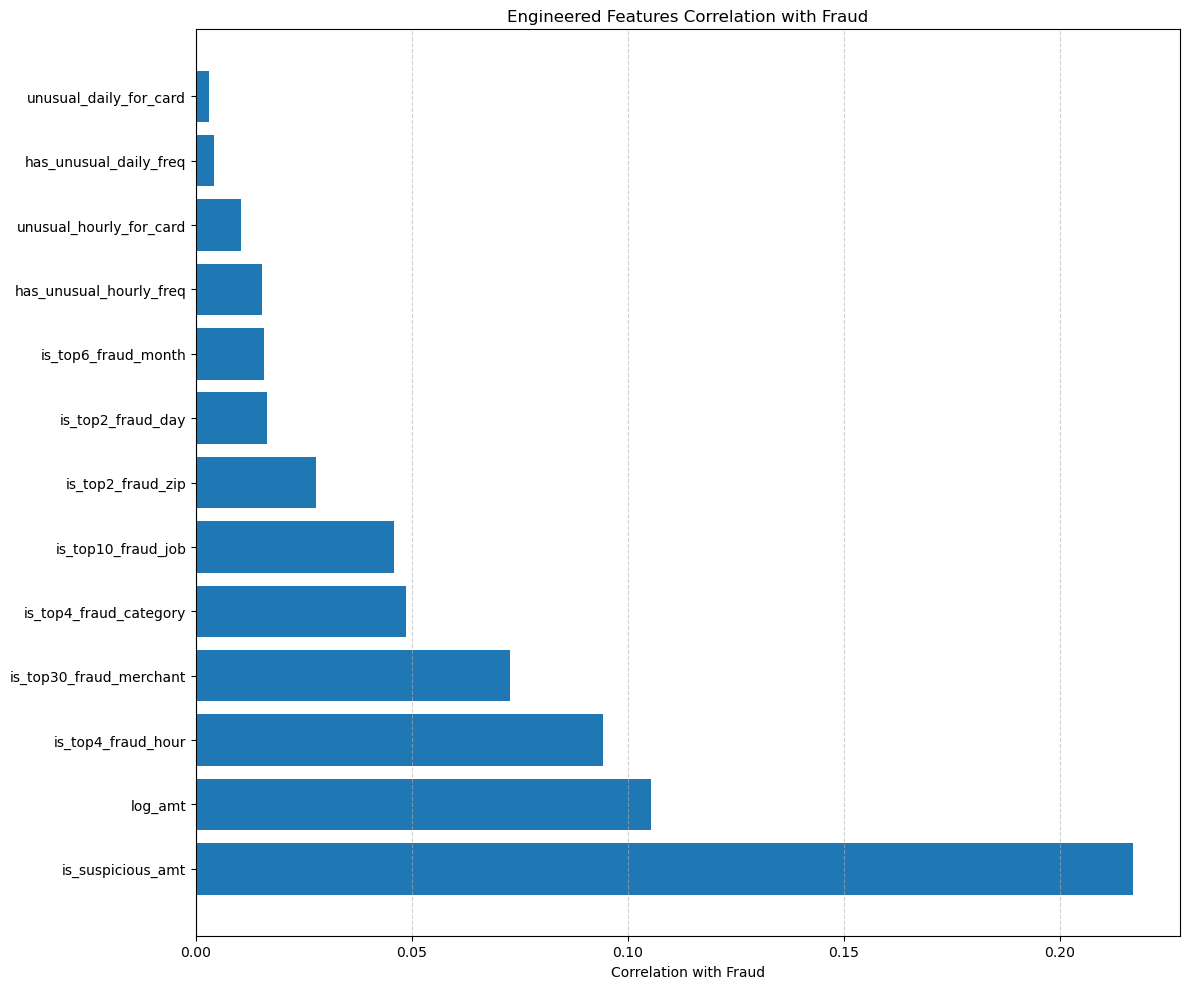


=== Engineered Features Summary ===
       is_top30_fraud_merchant  is_top4_fraud_category  is_top10_fraud_job  \
count            108102.000000           108102.000000       108102.000000   
mean                  0.043477                0.147481            0.004190   
std                   0.203930                0.354586            0.064598   
min                   0.000000                0.000000            0.000000   
25%                   0.000000                0.000000            0.000000   
50%                   0.000000                0.000000            0.000000   
75%                   0.000000                0.000000            0.000000   
max                   1.000000                1.000000            1.000000   

       is_top4_fraud_hour  is_top6_fraud_month  is_top2_fraud_day  \
count       108102.000000        108102.000000      108102.000000   
mean             0.170950             0.415432           0.211245   
std              0.376467             0.492799       

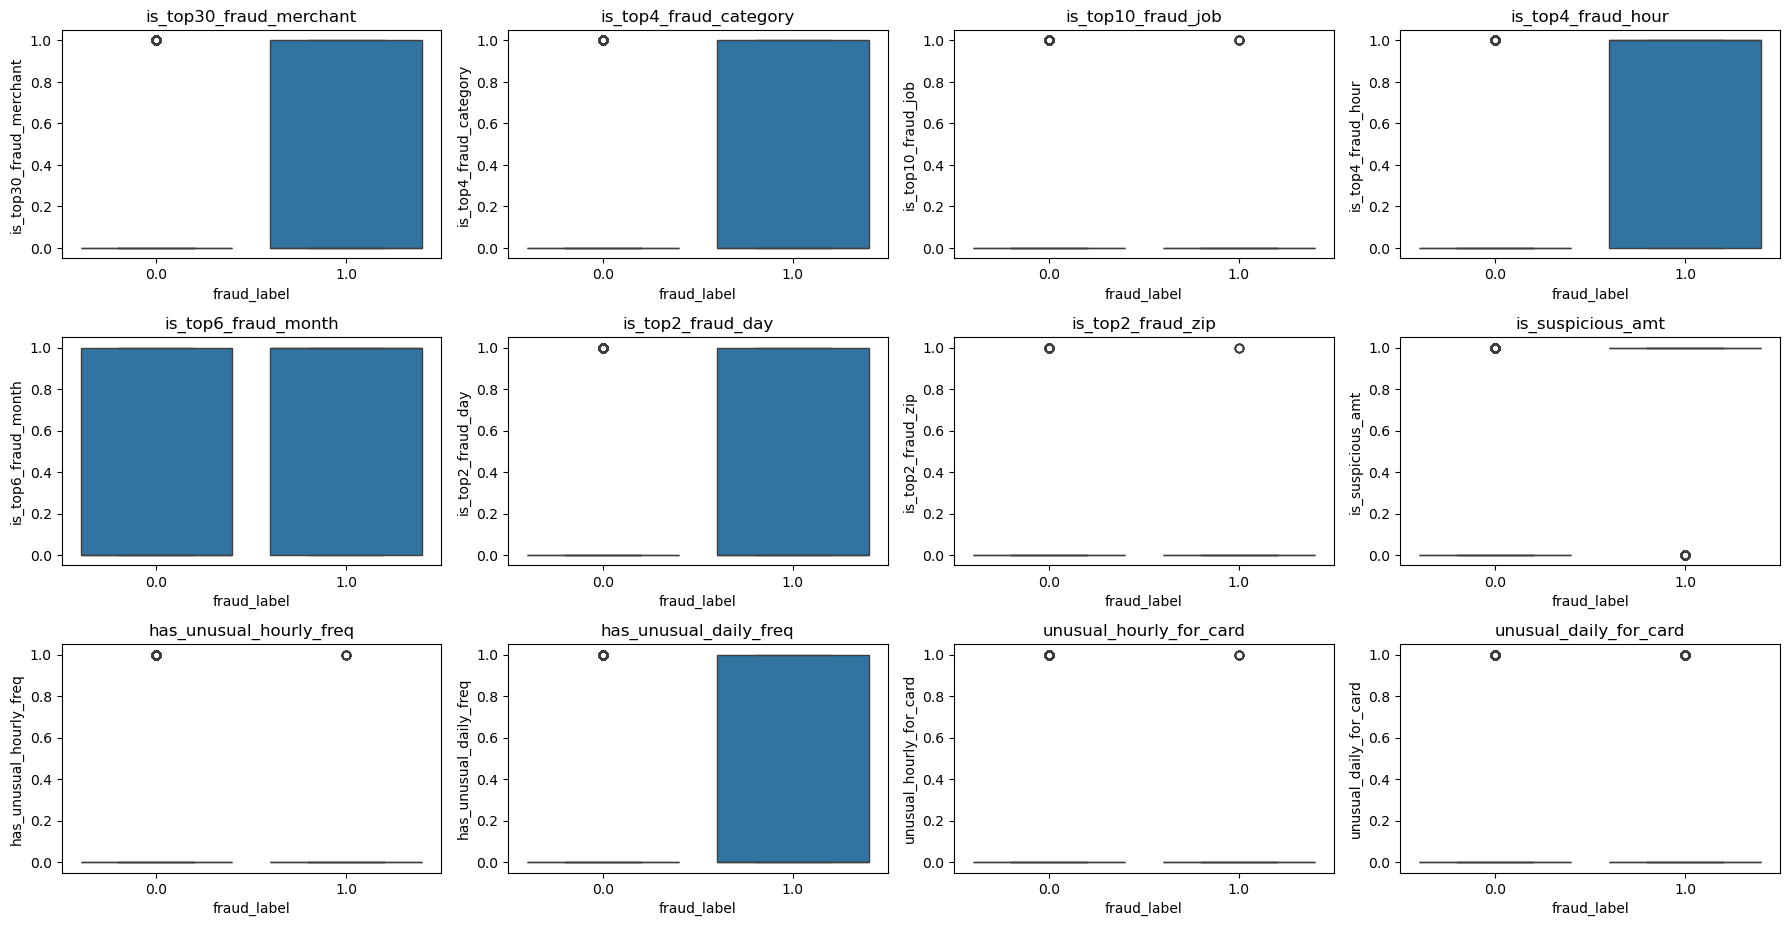


Final engineered dataset shape: (108102, 14)
Binary features created: 12


,is_top30_fraud_merchant,is_top4_fraud_category,is_top10_fraud_job,is_top4_fraud_hour,is_top6_fraud_month,is_top2_fraud_day,is_top2_fraud_zip,log_amt,is_suspicious_amt,has_unusual_hourly_freq,has_unusual_daily_freq,unusual_hourly_for_card,unusual_daily_for_card,fraud_label
632878,0,0,0,0,1,1,0,4.419804,0,0,0,0,0,0.0
921676,0,0,0,0,1,1,0,2.243896,0,0,0,0,0,0.0
303977,0,0,0,0,1,0,0,4.639282,0,0,0,0,0,0.0
24577,0,0,0,1,1,0,0,4.412556,0,0,0,0,0,0.0
571259,0,0,0,0,1,1,0,1.043804,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570009,0,0,0,0,0,0,0,4.422809,0,0,0,0,0,0.0
556298,0,0,0,0,0,0,0,4.147727,0,0,0,0,0,0.0
644251,0,0,0,0,0,0,0,3.524300,0,0,1,0,1,0.0
969731,1,1,0,0,0,0,0,4.153871,0,0,0,0,0,0.0


In [8]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Assuming we have the encoded_data DataFrame with all columns mentioned earlier
# First, let's create a copy to work with
df = encoded_data.copy()

# Helper function to get top N categories with highest fraud rates
def get_top_fraud_categories(df, column, n=10, min_count=50):
    # Group by the column and calculate fraud rate and total count
    fraud_rates = df.groupby(column).agg({
        'fraud_label': ['mean', 'count']
    })
    
    # Flatten the multi-index columns
    fraud_rates.columns = ['fraud_rate', 'count']
    
    # Filter out categories with too few transactions
    fraud_rates = fraud_rates[fraud_rates['count'] >= min_count]
    
    # Sort by fraud rate in descending order and get top N
    top_categories = fraud_rates.sort_values('fraud_rate', ascending=False).head(n).index.tolist()
    
    print(f"Top {n} {column} categories by fraud rate:")
    for cat in top_categories:
        rate = fraud_rates.loc[cat, 'fraud_rate'] * 100
        count = fraud_rates.loc[cat, 'count']
        print(f"  {cat}: {rate:.2f}% fraud rate ({count} transactions)")
    
    return top_categories

# 1. Create binary features for top merchants with fraud
print("\n=== Top Merchants with Fraud ===")
top_fraud_merchants = get_top_fraud_categories(df, 'merchant', n=30, min_count=20)
df['is_top30_fraud_merchant'] = df['merchant'].isin(top_fraud_merchants).astype(int)

# 2. Create binary features for top categories with fraud
print("\n=== Top Categories with Fraud ===")
top_fraud_categories = get_top_fraud_categories(df, 'category', n=4, min_count=20)
df['is_top4_fraud_category'] = df['category'].isin(top_fraud_categories).astype(int)

# 3. Create binary features for top jobs with fraud
print("\n=== Top Jobs with Fraud ===")
top_fraud_jobs = get_top_fraud_categories(df, 'job', n=10, min_count=10)
df['is_top10_fraud_job'] = df['job'].isin(top_fraud_jobs).astype(int)

# 4. Create binary features for top hours with fraud
print("\n=== Top Hours with Fraud ===")
top_fraud_hours = get_top_fraud_categories(df, 'hour', n=4)
df['is_top4_fraud_hour'] = df['hour'].isin(top_fraud_hours).astype(int)

# 5. Create binary features for top months with fraud
print("\n=== Top Months with Fraud ===")
top_fraud_months = get_top_fraud_categories(df, 'month_date', n=6)
df['is_top6_fraud_month'] = df['month_date'].isin(top_fraud_months).astype(int)

# 6. Create binary features for top days with fraud
print("\n=== Top Days with Fraud ===")
top_fraud_days = get_top_fraud_categories(df, 'day_of_week', n=2)
df['is_top2_fraud_day'] = df['day_of_week'].isin(top_fraud_days).astype(int)

# 7. Create binary features for top zip codes with fraud
print("\n=== Top ZIP Codes with Fraud ===")
top_fraud_zips = get_top_fraud_categories(df, 'zip', n=2, min_count=10)
df['is_top2_fraud_zip'] = df['zip'].isin(top_fraud_zips).astype(int)

# 8. Log transform the amount column
df['log_amt'] = np.log1p(df['amt'])  # log1p to handle zero amounts

# 9. Create binary feature for suspicious amounts
# Find transaction amounts that are more common in fraud cases
print("\n=== Suspicious Transaction Amounts ===")
# Bin amounts into ranges
df['amt_bin'] = pd.qcut(df['amt'], 20, duplicates='drop')

# Calculate fraud rate for each bin
amt_fraud_rates = df.groupby('amt_bin').agg({
    'fraud_label': ['mean', 'count']
})
amt_fraud_rates.columns = ['fraud_rate', 'count']

# Get overall fraud rate
overall_fraud_rate = df['fraud_label'].mean()

# Find bins with significantly higher fraud rates
significant_bins = amt_fraud_rates[amt_fraud_rates['fraud_rate'] > 2 * overall_fraud_rate].index.tolist()
df['is_suspicious_amt'] = df['amt_bin'].isin(significant_bins).astype(int)

# Display the suspicious amount ranges
print(f"Overall fraud rate: {overall_fraud_rate*100:.2f}%")
print("Amount ranges with high fraud rates:")
for bin_range in significant_bins:
    rate = amt_fraud_rates.loc[bin_range, 'fraud_rate'] * 100
    count = amt_fraud_rates.loc[bin_range, 'count']
    print(f"  {bin_range}: {rate:.2f}% fraud rate ({count} transactions)")

# Remove the temporary bin column
df.drop('amt_bin', axis=1, inplace=True)

# 10. Create features for unusual transaction frequency
print("\n=== Unusual Transaction Frequency ===")

# First, sort by cc_num and unix_time
df.sort_values(['cc_num', 'unix_time'], inplace=True)

# For each credit card, calculate:
# - How many transactions in the last hour
# - How many transactions in the last 24 hours
hour_in_seconds = 3600  # 1 hour
day_in_seconds = 86400  # 24 hours

# Initialize columns
df['tx_last_hour'] = 0
df['tx_last_day'] = 0

# Group by credit card
for cc, group in df.groupby('cc_num'):
    # Sort by time
    group = group.sort_values('unix_time')
    
    # For each transaction, count recent ones
    for i, row in enumerate(group.itertuples()):
        current_time = row.unix_time
        
        # Count transactions in last hour
        hour_count = sum(1 for prev_row in group.itertuples() 
                         if current_time - hour_in_seconds <= prev_row.unix_time < current_time)
        
        # Count transactions in last day
        day_count = sum(1 for prev_row in group.itertuples() 
                       if current_time - day_in_seconds <= prev_row.unix_time < current_time)
        
        # Update counts in the original dataframe
        df.loc[row.Index, 'tx_last_hour'] = hour_count
        df.loc[row.Index, 'tx_last_day'] = day_count

# Calculate normal transaction frequency for non-fraud transactions
legitimate_hourly_avg = df[df['fraud_label'] == 0].groupby('cc_num')['tx_last_hour'].mean()
legitimate_daily_avg = df[df['fraud_label'] == 0].groupby('cc_num')['tx_last_day'].mean()

# Calculate average and standard deviation of these averages
avg_hourly = legitimate_hourly_avg.mean()
std_hourly = legitimate_hourly_avg.std()
avg_daily = legitimate_daily_avg.mean()
std_daily = legitimate_daily_avg.std()

print(f"Average transactions per hour (legitimate): {avg_hourly:.2f} (std: {std_hourly:.2f})")
print(f"Average transactions per day (legitimate): {avg_daily:.2f} (std: {std_daily:.2f})")

# Create binary features for unusual frequency
# A frequency is unusual if it's more than 1.2 standard deviations above the mean
df['has_unusual_hourly_freq'] = (df['tx_last_hour'] > avg_hourly + 1.2 * std_hourly).astype(int)
df['has_unusual_daily_freq'] = (df['tx_last_day'] > avg_daily + 1.2 * std_daily).astype(int)

# Create a feature for unusual frequency for this specific card
# First, create a mapping of average frequencies per card (for non-fraud transactions)
card_hourly_avg = df[df['fraud_label'] == 0].groupby('cc_num')['tx_last_hour'].mean().to_dict()
card_daily_avg = df[df['fraud_label'] == 0].groupby('cc_num')['tx_last_day'].mean().to_dict()

# Apply this to create card-specific unusualness features
df['hourly_vs_card_avg'] = df.apply(
    lambda row: row['tx_last_hour'] / card_hourly_avg.get(row['cc_num'], avg_hourly) 
    if card_hourly_avg.get(row['cc_num'], avg_hourly) > 0 else 0, 
    axis=1
)
df['daily_vs_card_avg'] = df.apply(
    lambda row: row['tx_last_day'] / card_daily_avg.get(row['cc_num'], avg_daily)
    if card_daily_avg.get(row['cc_num'], avg_daily) > 0 else 0,
    axis=1
)

# Create binary features for card-specific unusual frequency
df['unusual_hourly_for_card'] = (df['hourly_vs_card_avg'] > 3).astype(int)  # More than 3x normal
df['unusual_daily_for_card'] = (df['daily_vs_card_avg'] > 2).astype(int)   # More than 2x normal

# Keep only engineered features and drop original columns
engineered_features = [
    'is_top30_fraud_merchant',
    'is_top4_fraud_category',
    'is_top10_fraud_job',
    'is_top4_fraud_hour',
    'is_top6_fraud_month',
    'is_top2_fraud_day',
    'is_top2_fraud_zip',
    'log_amt',
    'is_suspicious_amt',
    'tx_last_hour',
    'tx_last_day',
    'has_unusual_hourly_freq',
    'has_unusual_daily_freq',
    'unusual_hourly_for_card',
    'unusual_daily_for_card',
    'fraud_label'  # Keep the target variable
]

# Create the final engineered dataframe
final_df = df[engineered_features]


# drop

# After creating all your engineered features in final_df

# List of columns to keep (only binary features and fraud_label)
binary_features = [
    'is_top30_fraud_merchant',
    'is_top4_fraud_category',
    'is_top10_fraud_job',
    'is_top4_fraud_hour',
    'is_top6_fraud_month',
    'is_top2_fraud_day',
    'is_top2_fraud_zip',
    'is_suspicious_amt',
    'has_unusual_hourly_freq',
    'has_unusual_daily_freq',
    'unusual_hourly_for_card',
    'unusual_daily_for_card',
    'fraud_label'  # Keep the target variable
]

# Explicitly drop the non-binary features
columns_to_drop = [
         # Continuous log-transformed amount
    'tx_last_hour', # Count of transactions in last hour
    'tx_last_day',  # Count of transactions in last day
    # Add any other non-binary features that might be in your dataframe
]

# Create the final binary-only dataframe
binary_df = final_df.drop(columns=columns_to_drop)

# Alternatively, you can directly select only the binary columns
# binary_df = final_df[binary_features]

# Verify that only binary features remain
print("Final binary dataset shape:", binary_df.shape)
print("Columns in final binary dataset:", binary_df.columns.tolist())

# Check that all remaining features are truly binary (0 or 1 values only)
for col in binary_df.columns:
    if col != 'fraud_label':  # Skip the target variable
        unique_values = binary_df[col].unique()
        is_binary = set(unique_values).issubset({0, 1})
        print(f"{col}: Binary = {is_binary}, Unique values = {unique_values}")

# Now you can proceed with your train/test split using binary_df
final_df = binary_df  # Update your working dataframe to only include binary features





# Show the correlation between engineered features and fraud
plt.figure(figsize=(12, 10))
correlation = final_df.corr()['fraud_label'].sort_values(ascending=False)
correlation = correlation.drop('fraud_label')  # Remove self-correlation

# Plot correlation of features with fraud
plt.barh(range(len(correlation)), correlation.values)
plt.yticks(range(len(correlation)), correlation.index)
plt.xlabel('Correlation with Fraud')
plt.title('Engineered Features Correlation with Fraud')
plt.axvline(x=0, color='gray', linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Display summary statistics of the engineered features
print("\n=== Engineered Features Summary ===")
print(final_df.describe())

# Display feature value distributions grouped by fraud/non-fraud
plt.figure(figsize=(18, 12))
for i, feature in enumerate(binary_features[:-1]):  # Exclude fraud_label
    plt.subplot(4, 4, i+1)
    sns.boxplot(x='fraud_label', y=feature, data=final_df)
    plt.title(feature)
    plt.tight_layout()
plt.show()

print("\nFinal engineered dataset shape:", final_df.shape)
print("Binary features created:", sum(1 for col in final_df.columns if col.startswith('is_') or col.startswith('has_') or col.startswith('unusual_')))

# Save the final dataframe if needed
# final_df.to_csv('engineered_fraud_features.csv', index=False)

# Return the final dataframe with engineered features
final_df


=== Dataset Information ===
DataFrame shape: (108102, 14)

Column datatypes:
is_top30_fraud_merchant      int32
is_top4_fraud_category       int32
is_top10_fraud_job           int32
is_top4_fraud_hour           int32
is_top6_fraud_month          int32
is_top2_fraud_day            int32
is_top2_fraud_zip            int32
log_amt                    float64
is_suspicious_amt            int32
has_unusual_hourly_freq      int32
has_unusual_daily_freq       int32
unusual_hourly_for_card      int32
unusual_daily_for_card       int32
fraud_label                float64
dtype: object

Sample data:
        is_top30_fraud_merchant  is_top4_fraud_category  is_top10_fraud_job  \
632878                        0                       0                   0   
921676                        0                       0                   0   
303977                        0                       0                   0   
24577                         0                       0                   0   
571259   

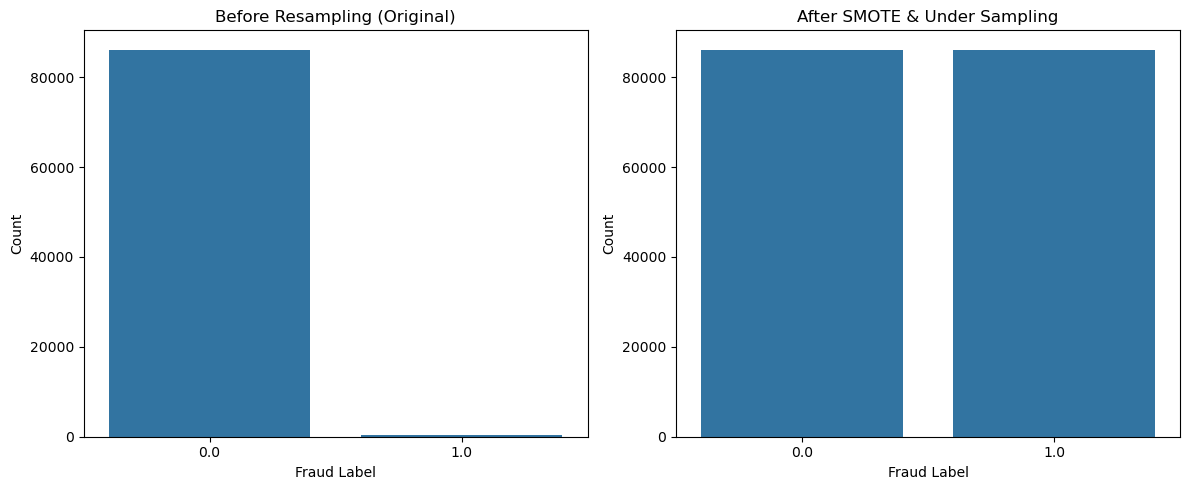


=== Feature Correlations After Resampling ===

All feature correlations with fraud_label:
is_suspicious_amt          0.735018
is_top4_fraud_hour         0.530687
is_top4_fraud_category     0.284315
is_top30_fraud_merchant    0.279922
is_top6_fraud_month        0.095299
is_top2_fraud_day          0.070718
has_unusual_hourly_freq    0.027765
has_unusual_daily_freq     0.019687
is_top10_fraud_job         0.017333
unusual_daily_for_card     0.016958
unusual_hourly_for_card    0.015035
is_top2_fraud_zip         -0.015844
log_amt                         NaN
Name: fraud_label, dtype: float64

Dropping the bottom 9 features (least correlated with fraud_label):
['unusual_hourly_for_card', 'is_top2_fraud_zip', 'unusual_daily_for_card', 'is_top10_fraud_job', 'has_unusual_daily_freq', 'has_unusual_hourly_freq', 'is_top2_fraud_day', 'is_top6_fraud_month', 'is_top30_fraud_merchant']


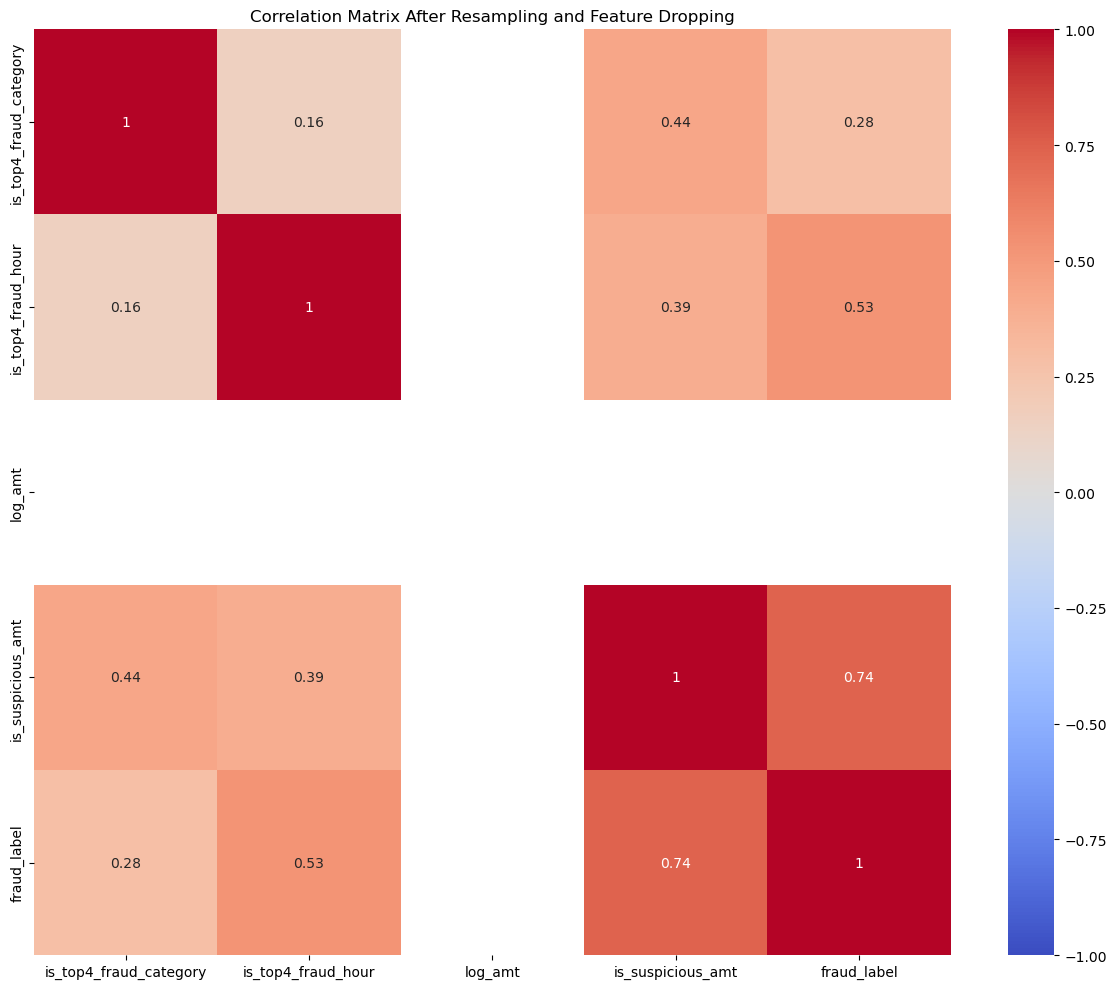


=== Final Dataset Sizes ===
Original training set: (86480, 4)
Validation set: (10811, 4)
Test set: (10811, 4)
Resampled training set: (172208, 4)


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def prepare_data(df, test_size=0.1, val_size=0.1, 
                 smote_ratio=1.0, undersample_ratio=0.0, random_state=42):
    """
    Split data into train, validation and test sets.
    Optionally apply SMOTE to oversample the minority class if smote_ratio > 0,
    then optionally apply RandomUnderSampler to undersample the majority class if undersample_ratio > 0.
    Then, threshold binary features (except for 'log amt') and drop the bottom 9 features 
    (i.e. those with the lowest absolute correlation with fraud_label).
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing features and target variable 'fraud_label'.
    test_size : float, default=0.1
        Proportion of data for test set.
    val_size : float, default=0.1
        Proportion of data for validation set.
    smote_ratio : float, default=1.0
        Desired minority-to-majority ratio after SMOTE oversampling 
        (1.0 means fully balanced). If set to 0, SMOTE is skipped.
    undersample_ratio : float, default=0.0
        Desired minority-to-majority ratio after RandomUnderSampler undersampling.
        If set to 0, undersampling is skipped.
    random_state : int, default=42
        Random state for reproducibility.
        
    Returns:
    --------
    X_train, X_val, X_test, y_train, y_val, y_test, 
    X_train_resampled, y_train_resampled (with the bottom 9 features dropped)
    """
    # Print dataset information
    print("\n=== Dataset Information ===")
    print(f"DataFrame shape: {df.shape}")
    print("\nColumn datatypes:")
    print(df.dtypes)
    print("\nSample data:")
    print(df.head())
    print("\nClass distribution:")
    print(df['fraud_label'].value_counts())
    print(f"Fraud percentage: {df['fraud_label'].mean() * 100:.2f}%")
    
    # Split features and target
    X = df.drop('fraud_label', axis=1)
    y = df['fraud_label']
    
    # First split: training+validation vs test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Second split: training vs validation
    adjusted_val_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=adjusted_val_size, random_state=random_state, stratify=y_temp
    )
    
    # Print split sizes and class distributions
    print("\n=== Data Split Information ===")
    print(f"Training set: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
    print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(df)*100:.1f}%)")
    print(f"Test set: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")
    print("\nClass distribution in splits:")
    print(f"  Training: {y_train.mean()*100:.2f}% fraud")
    print(f"  Validation: {y_val.mean()*100:.2f}% fraud")
    print(f"  Test: {y_test.mean()*100:.2f}% fraud")
    
    # Apply SMOTE oversampling if smote_ratio > 0
    if smote_ratio > 0:
        if smote_ratio == 1.0:
            sampling_strategy = 'auto'  # fully balance the classes
        else:
            n_majority = (y_train == 0).sum()
            sampling_strategy = {1: int(n_majority * smote_ratio)}
        print("\n=== Applying SMOTE Oversampling ===")
        print(f"Target minority:majority ratio after SMOTE: {smote_ratio:.2f}")
        smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        # Convert the resampled features to a DataFrame and threshold binary features
        X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
        binary_cols = [col for col in X_train.columns if col != 'log amt']
        X_train_resampled[binary_cols] = (X_train_resampled[binary_cols] >= 0.5).astype(int)
    else:
        print("\n=== Skipping SMOTE Oversampling ===")
        X_train_resampled, y_train_resampled = X_train.copy(), y_train.copy()
    
    # Apply RandomUnderSampler undersampling if undersample_ratio > 0
    if undersample_ratio > 0:
        print("\n=== Applying Random Under Sampling ===")
        print(f"Target minority:majority ratio after undersampling: {undersample_ratio:.2f}")
        rus = RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=random_state)
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)
    else:
        print("\n=== Skipping Under Sampling ===")
    
    # Print class distributions after resampling
    print("Original training class distribution:")
    print(pd.Series(y_train).value_counts())
    print(f"Original fraud percentage: {y_train.mean()*100:.2f}%")
    print("\nResampled training class distribution:")
    print(pd.Series(y_train_resampled).value_counts())
    print(f"Resampled fraud percentage: {np.mean(y_train_resampled)*100:.2f}%")
    
    # Visualize class distribution before and after resampling
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=y_train)
    plt.title('Before Resampling (Original)')
    plt.xlabel('Fraud Label')
    plt.ylabel('Count')
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_train_resampled)
    title_str = 'After SMOTE & Under Sampling' if (smote_ratio > 0 or undersample_ratio > 0) else 'No Resampling Applied'
    plt.title(title_str)
    plt.xlabel('Fraud Label')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Compute correlations on the resampled training set
    print("\n=== Feature Correlations After Resampling ===")
    resampled_df = X_train_resampled.copy()
    resampled_df['fraud_label'] = y_train_resampled
    correlations = resampled_df.corr()['fraud_label'].drop('fraud_label')
    print("\nAll feature correlations with fraud_label:")
    print(correlations.sort_values(ascending=False))
    
    # Identify and drop the bottom 9 features (least correlated in absolute value)
    abs_corr = correlations.abs()
    features_to_drop = abs_corr.sort_values(ascending=True).head(9).index.tolist()
    print("\nDropping the bottom 9 features (least correlated with fraud_label):")
    print(features_to_drop)
    
    # Drop these features from all datasets
    X_train = X_train.drop(columns=features_to_drop)
    X_val = X_val.drop(columns=features_to_drop)
    X_test = X_test.drop(columns=features_to_drop)
    X_train_resampled = X_train_resampled.drop(columns=features_to_drop)
    
    # Plot correlation heatmap of the resampled data after dropping features
    resampled_df = X_train_resampled.copy()
    resampled_df['fraud_label'] = y_train_resampled
    plt.figure(figsize=(12, 10))
    sns.heatmap(resampled_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Matrix After Resampling and Feature Dropping')
    plt.tight_layout()
    plt.show()
    
    return X_train, X_val, X_test, y_train, y_val, y_test, X_train_resampled, y_train_resampled

# Example usage:
# Assuming final_df is your dataframe with a 'fraud_label' column and a 'log amt' column.
X_train, X_val, X_test, y_train, y_val, y_test, X_train_resampled, y_train_resampled = prepare_data(
    final_df, 
    test_size=0.1, 
    val_size=0.1, 
    smote_ratio=1.0,         # Apply SMOTE oversampling
    undersample_ratio=1.0,   # Then apply undersampling to get balanced classes
    random_state=42
)

print("\n=== Final Dataset Sizes ===")
print(f"Original training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Resampled training set: {X_train_resampled.shape if X_train_resampled is not None else 'None'}")


Using SMOTE-resampled training data (ratio: 0)

Default hyperparameter grids for grid search:
XGBoost: {'n_estimators': [50, 60, 70, 80, 90, 100], 'max_depth': [4, 5, 10, 15, 20], 'learning_rate': [0.01, 0.1]}
Random Forest: {'n_estimators': [10, 20, 30, 40, 50], 'max_depth': [None, 15, 20, 30], 'min_samples_split': [2, 3, 4, 5]}
Neural Network: {'hidden_dim': [30, 40, 50], 'num_hidden_layers': [1], 'lr': [0.01, 0.1], 'num_epochs': [10, 20, 30], 'batch_size': [32]}

==== Grid Search and Training for XGBoost ====
Best hyperparameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}
Cross-validation F1 scores: [0.87892944 0.87734369 0.87852727 0.87750337 0.87982196]
Mean CV F1 score: 0.878

Validation set metrics (default threshold):
Precision: 0.022
Recall: 0.957
ROC AUC: 0.956
PR AUC: 0.186

Classification Report (Validation Set):
              precision    recall  f1-score   support

         0.0       1.00      0.81      0.90     10764
         1.0       0.02 

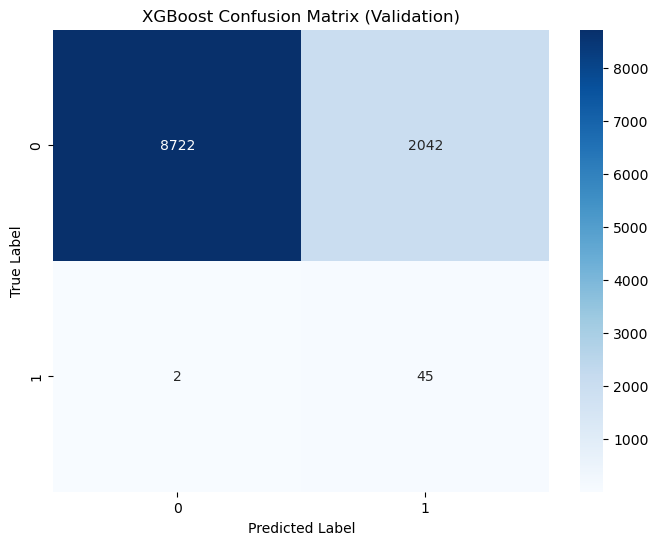


Optimal threshold for XGBoost: 0.694
At optimal threshold - Precision: 0.306, Recall: 0.234


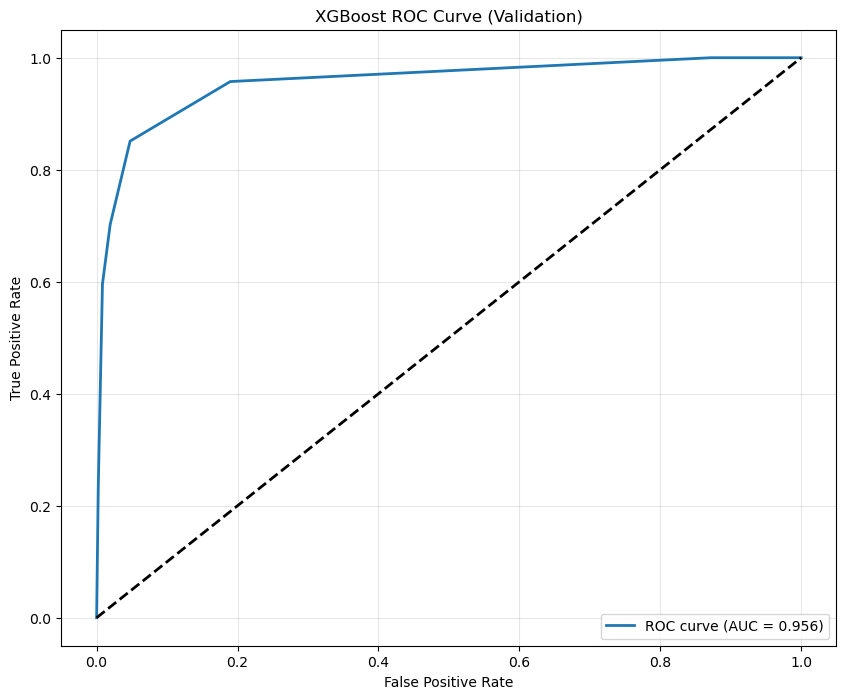

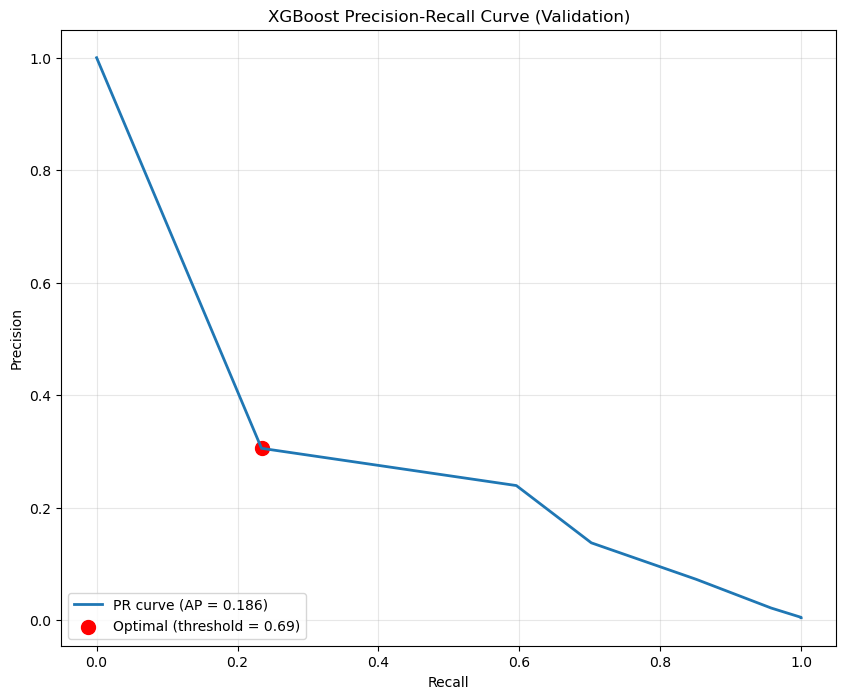

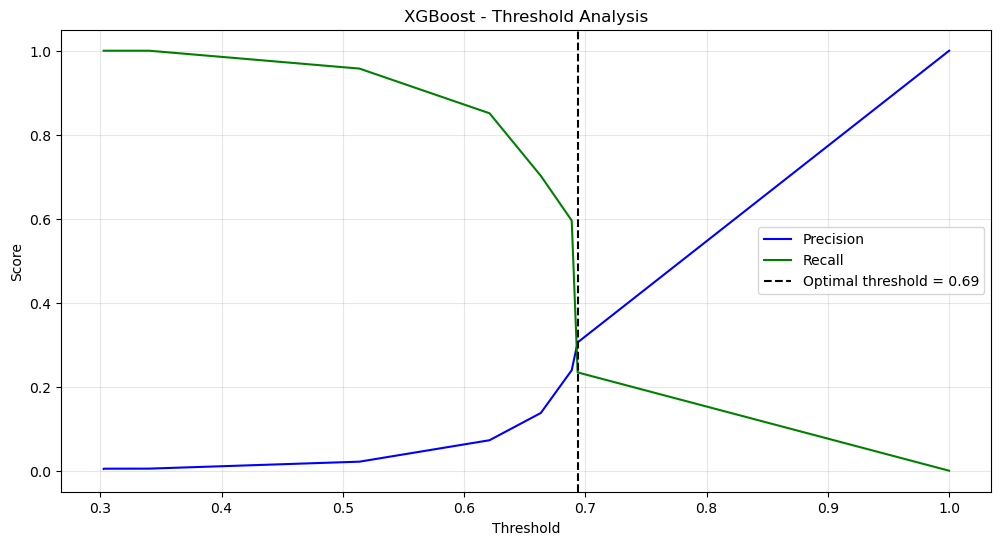

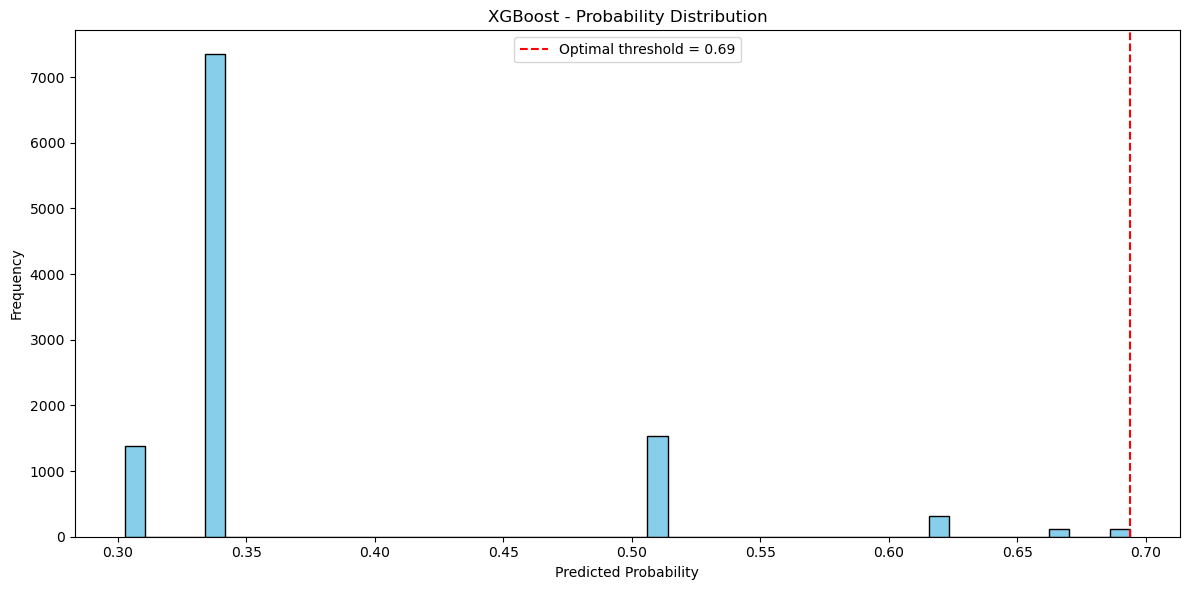


Test Set Results (Raw Predictions):
Default threshold - Precision: 0.022, Recall: 0.936
Optimal threshold - Precision: 0.263, Recall: 0.213
ROC AUC: 0.930
PR AUC: 0.129

Test Set Results (After Applying Fraud Rule):
Precision: 0.005, Recall: 0.043

Classification Report (Test Set, Optimal Threshold):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10764
         1.0       0.26      0.21      0.24        47

    accuracy                           0.99     10811
   macro avg       0.63      0.61      0.62     10811
weighted avg       0.99      0.99      0.99     10811


Classification Report (Test Set, After Fraud Rule):
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     10764
         1.0       0.01      0.04      0.01        47

    accuracy                           0.96     10811
   macro avg       0.50      0.50      0.49     10811
weighted avg       0.99      0.96      0.98  

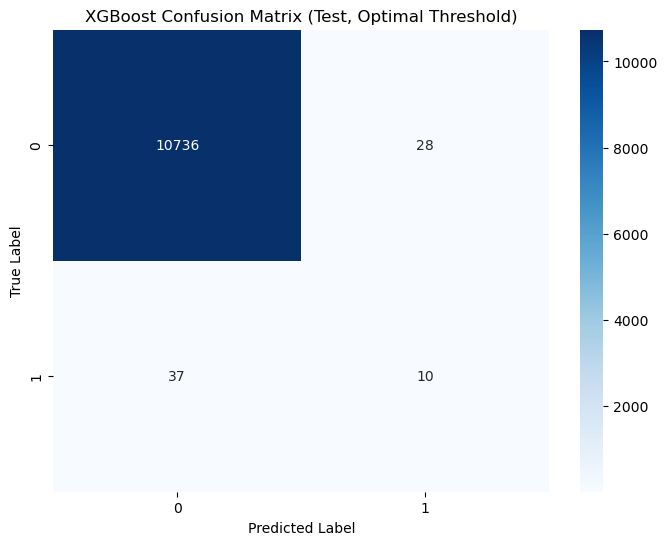


==== Grid Search and Training for Random Forest ====
Best hyperparameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 10}
Cross-validation F1 scores: [0.87892944 0.87734369 0.87852727 0.87750337 0.87982196]
Mean CV F1 score: 0.878

Validation set metrics (default threshold):
Precision: 0.022
Recall: 0.957
ROC AUC: 0.956
PR AUC: 0.186

Classification Report (Validation Set):
              precision    recall  f1-score   support

         0.0       1.00      0.81      0.90     10764
         1.0       0.02      0.96      0.04        47

    accuracy                           0.81     10811
   macro avg       0.51      0.88      0.47     10811
weighted avg       1.00      0.81      0.89     10811



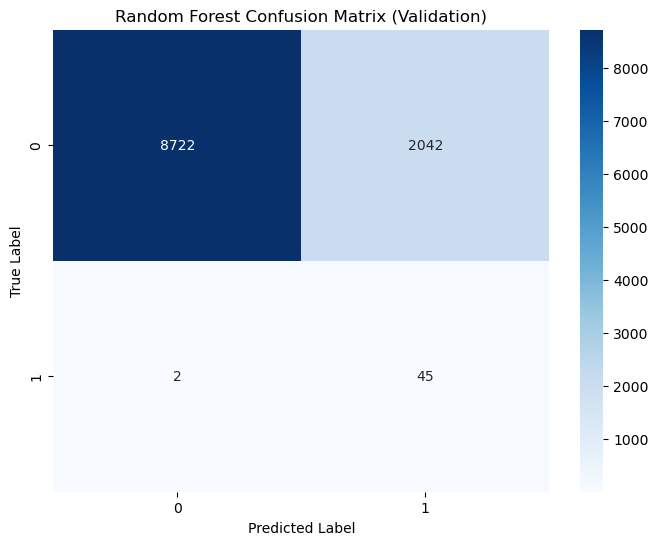


Optimal threshold for Random Forest: 0.991
At optimal threshold - Precision: 0.306, Recall: 0.234


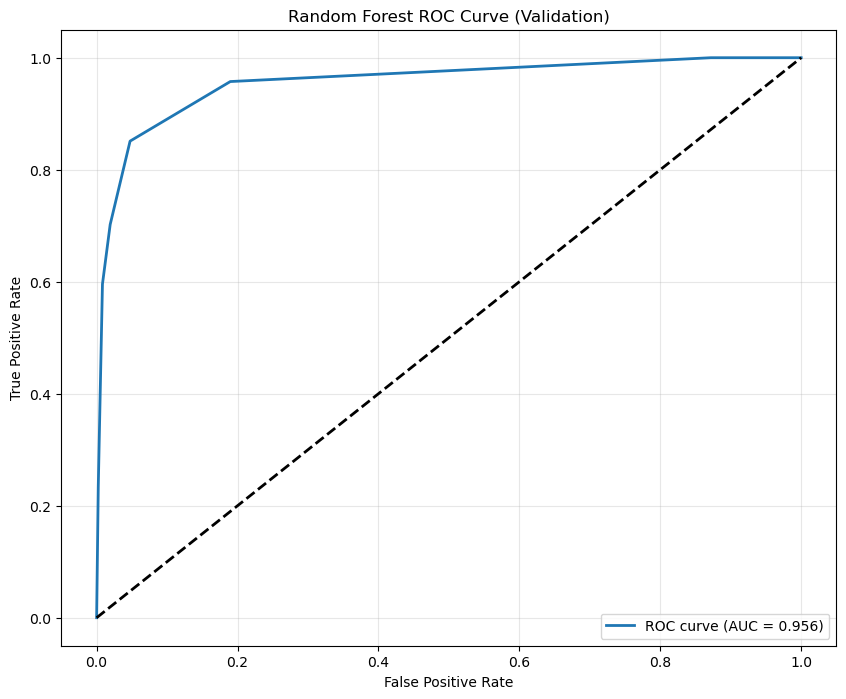

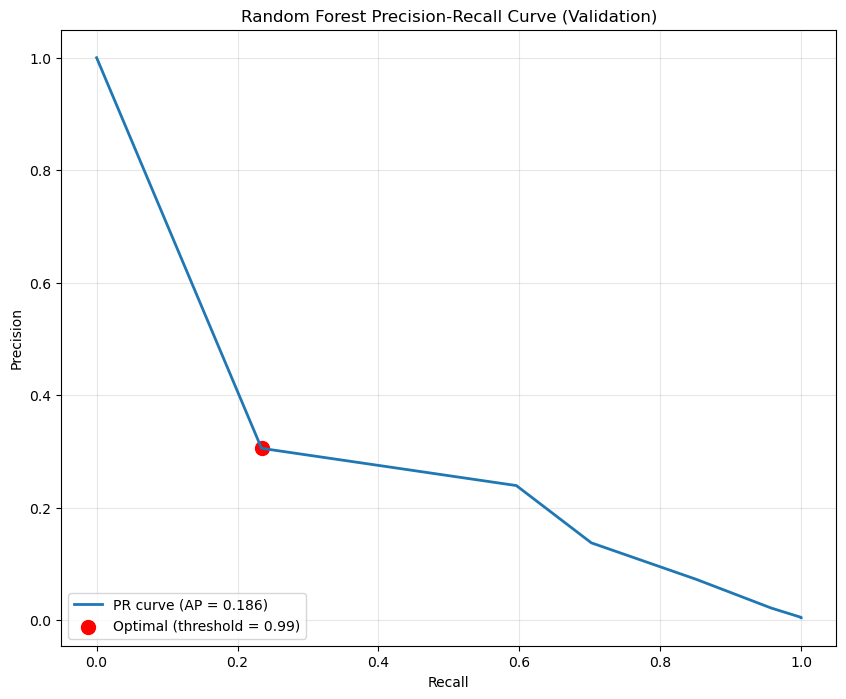

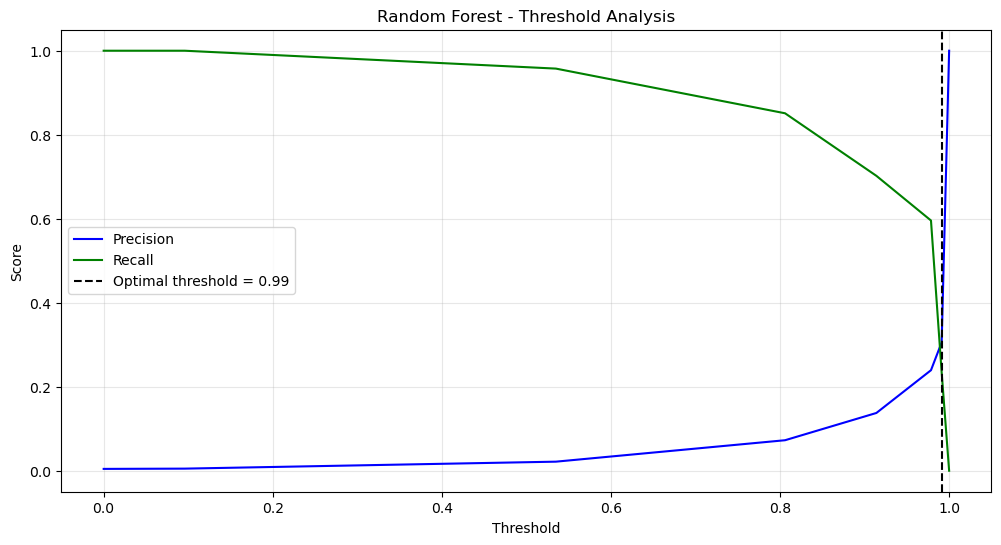

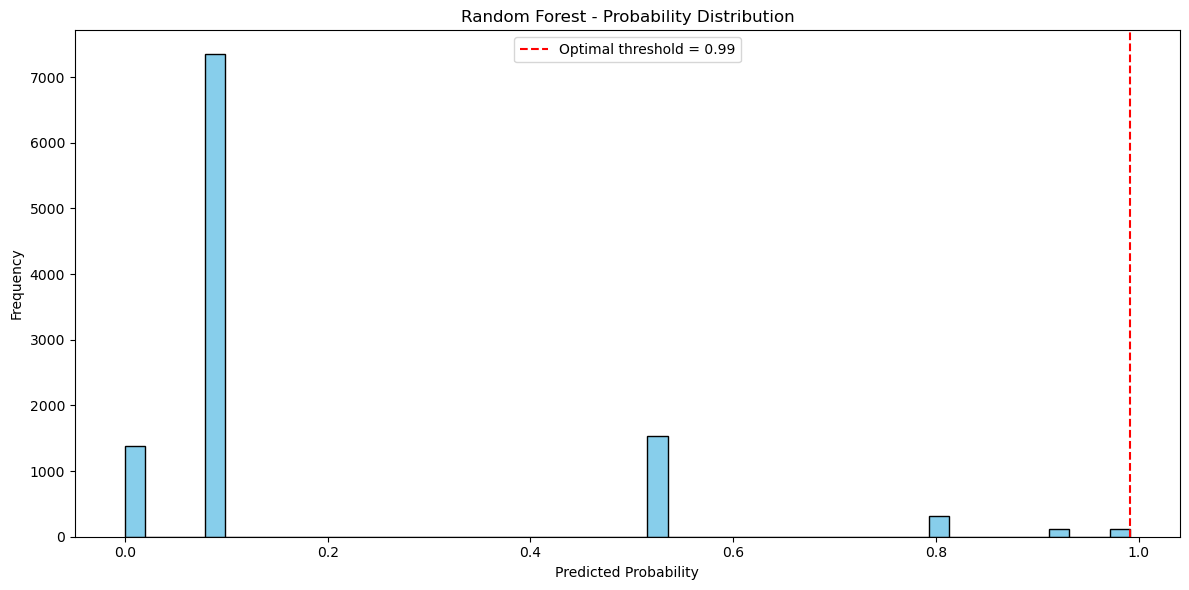


Test Set Results (Raw Predictions):
Default threshold - Precision: 0.022, Recall: 0.936
Optimal threshold - Precision: 0.263, Recall: 0.213
ROC AUC: 0.930
PR AUC: 0.129

Test Set Results (After Applying Fraud Rule):
Precision: 0.005, Recall: 0.043

Classification Report (Test Set, Optimal Threshold):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10764
         1.0       0.26      0.21      0.24        47

    accuracy                           0.99     10811
   macro avg       0.63      0.61      0.62     10811
weighted avg       0.99      0.99      0.99     10811


Classification Report (Test Set, After Fraud Rule):
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     10764
         1.0       0.01      0.04      0.01        47

    accuracy                           0.96     10811
   macro avg       0.50      0.50      0.49     10811
weighted avg       0.99      0.96      0.98  

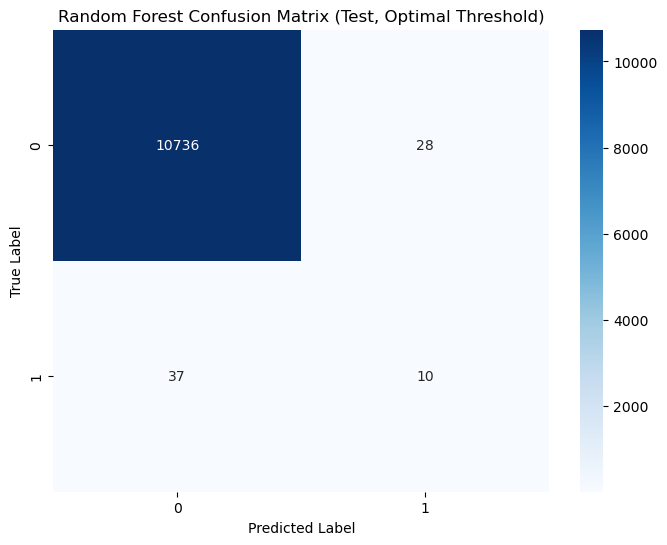


==== Grid Search and Training for Neural Network ====


KeyboardInterrupt: 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch and related imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin

# Sklearn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score, precision_score,
    recall_score, f1_score
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import xgboost as xgb

#############################################
# Define a PyTorch Neural Network Wrapper with Dropout and BatchNorm
#############################################
class TorchNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden_dim=32, num_hidden_layers=1, lr=0.001, 
                 num_epochs=10, batch_size=64, dropout=0.5, random_state=42, verbose=0, device=None):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_hidden_layers = num_hidden_layers
        self.lr = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.dropout = dropout
        self.random_state = random_state
        self.verbose = verbose
        
        # Set device (GPU if available)
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
        
        self._build_model()
    
    def _build_model(self):
        layers = []
        # First hidden layer: Linear -> BatchNorm -> ReLU -> Dropout
        layers.append(nn.Linear(self.input_dim, self.hidden_dim))
        layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=self.dropout))
        # Additional hidden layers (if any)
        for _ in range(self.num_hidden_layers - 1):
            layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            layers.append(nn.BatchNorm1d(self.hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=self.dropout))
        # Output layer
        layers.append(nn.Linear(self.hidden_dim, 1))
        self.model = nn.Sequential(*layers).to(self.device)
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
    
    def fit(self, X, y):
        torch.manual_seed(self.random_state)
        self._build_model()  # reinitialize model each time
        
        if isinstance(X, pd.DataFrame):
            X_tensor = torch.FloatTensor(X.values)
        else:
            X_tensor = torch.FloatTensor(X)
        if isinstance(y, pd.Series) or isinstance(y, pd.DataFrame):
            y_tensor = torch.FloatTensor(y.values).view(-1, 1)
        else:
            y_tensor = torch.FloatTensor(y).view(-1, 1)
        
        # Move tensors to device
        X_tensor = X_tensor.to(self.device)
        y_tensor = y_tensor.to(self.device)
        
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        self.model.train()
        for epoch in range(self.num_epochs):
            for batch_X, batch_y in loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
            if self.verbose:
                print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {loss.item():.4f}")
        return self
    
    def predict_proba(self, X):
        self.model.eval()
        if isinstance(X, pd.DataFrame):
            X_tensor = torch.FloatTensor(X.values)
        else:
            X_tensor = torch.FloatTensor(X)
        X_tensor = X_tensor.to(self.device)
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        return np.vstack([1 - probs, probs]).T
    
    def predict(self, X):
        probs = self.predict_proba(X)[:, 1]
        return (probs >= 0.5).astype(int)

#############################################
# Helper function: Apply Fraud Rule by cc_num and unix_time
#############################################
def apply_fraud_rule_by_cc(X, y_pred):
    """
    Given a DataFrame X that includes 'cc_num' and 'unix_time' columns and a numpy array y_pred
    (raw predictions for the test set), this function groups transactions by 'cc_num',
    sorts each group by 'unix_time', and then marks all transactions after the first predicted fraud
    as fraudulent.
    Returns an updated numpy array of predictions.
    """
    df = X[['cc_num', 'unix_time']].copy()
    df['pred'] = y_pred
    def process_group(group):
        group = group.sort_values('unix_time')
        fraud_found = False
        new_preds = []
        for p in group['pred']:
            if fraud_found:
                new_preds.append(1)
            elif p == 1:
                fraud_found = True
                new_preds.append(1)
            else:
                new_preds.append(0)
        group['pred_rule'] = new_preds
        return group
    df = df.groupby('cc_num', group_keys=False).apply(process_group)
    return df['pred_rule'].values

#############################################
# Define the evaluation function with grid search and fraud rule application
#############################################
def evaluate_fraud_models(X_train, X_val, X_test, y_train, y_val, y_test, 
                          X_train_resampled=None, y_train_resampled=None,
                          smote_ratio=None, cleaned_data=None, verbose=True):
    """
    Train and evaluate fraud detection models (XGBoost, Random Forest, and a PyTorch Neural Network)
    using grid search for hyperparameter tuning and threshold optimization.
    Additionally, for the test set, apply a fraud rule that, per cc_num and unix_time (accessed
    from cleaned_data), marks all transactions subsequent to a fraudulent transaction as fraud.
    Both the raw predictions and the rule-modified predictions are reported.
    
    Parameters:
    -----------
    X_train, X_val, X_test, y_train, y_val, y_test : training, validation, and test splits
    X_train_resampled, y_train_resampled : optional SMOTE-resampled training data
    smote_ratio : float, the SMOTE ratio used (for tracking in results)
    cleaned_data : pandas DataFrame, the original cleaned data containing at least 'cc_num' and 'unix_time'
                  for the test set. It is assumed that cleaned_data’s index overlaps with X_test.
    verbose : bool, whether to print detailed output and display plots
    
    Returns:
    --------
    Dictionary containing model performance metrics and results.
    """
    # Determine whether to use resampled data
    if X_train_resampled is not None and y_train_resampled is not None:
        X_train_use = X_train_resampled
        y_train_use = y_train_resampled
        print(f"Using SMOTE-resampled training data (ratio: {smote_ratio})")
    else:
        X_train_use = X_train
        y_train_use = y_train
        print("Using original training data (no SMOTE)")
    
    # Define default hyperparameter grids
    xgb_param_grid = {
        'n_estimators': [50, 60, 70, 80, 90, 100],
        'max_depth': [4, 5, 10, 15, 20],
        'learning_rate': [0.01, 0.1]
    }
    
    rf_param_grid = {
        'n_estimators': [10, 20, 30, 40, 50],
        'max_depth': [None, 15, 20, 30],
        'min_samples_split': [2, 3, 4, 5]
    }
    
    nn_param_grid = {
        'hidden_dim': [30, 40, 50],
        'num_hidden_layers': [1],
        'lr': [0.01, 0.1],
        'num_epochs': [10, 20, 30],
        'batch_size': [32]
    }
    
    # Print hyperparameter grids
    print("\nDefault hyperparameter grids for grid search:")
    print("XGBoost:", xgb_param_grid)
    print("Random Forest:", rf_param_grid)
    print("Neural Network:", nn_param_grid)
    
    # For XGBoost, if GPU is available, use GPU-accelerated parameters.
    if torch.cuda.is_available():
        xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',
                                      tree_method='gpu_hist', gpu_id=0)
    else:
        xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    
    # Initialize models – note that for the NN we must supply input_dim from X_train
    models = {
        'XGBoost': xgb_model,
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'Neural Network': TorchNNClassifier(input_dim=X_train.shape[1], random_state=42, verbose=0)
    }
    
    # Map each model to its corresponding hyperparameter grid
    param_grids = {
        'XGBoost': xgb_param_grid,
        'Random Forest': rf_param_grid,
        'Neural Network': nn_param_grid
    }
    
    # Dictionary to store results
    results = {
        'smote_ratio': smote_ratio,
        'models': {},
        'best_model': None,
        'best_threshold': None,
        'thresholds': {}
    }
    
    # For each model, run grid search and evaluate (using 'f1' for cross-validation remains, but threshold selection is modified)
    for name, model in models.items():
        print(f"\n==== Grid Search and Training for {name} ====")
        grid = GridSearchCV(estimator=model, param_grid=param_grids[name],
                            scoring='f1', cv=5, n_jobs=-1, verbose=0)
        grid.fit(X_train_use, y_train_use)
        best_model = grid.best_estimator_
        print(f"Best hyperparameters for {name}: {grid.best_params_}")
        
        # Cross validation on training data (using the best estimator)
        cv_scores = cross_val_score(best_model, X_train_use, y_train_use, cv=5, scoring='f1')
        print(f"Cross-validation F1 scores: {cv_scores}")
        print(f"Mean CV F1 score: {cv_scores.mean():.3f}")
        
        # Predict on validation set
        y_val_pred = best_model.predict(X_val)
        y_val_prob = best_model.predict_proba(X_val)[:, 1]
        
        # Calculate metrics on validation set
        val_precision = precision_score(y_val, y_val_pred)
        val_recall = recall_score(y_val, y_val_pred)
        val_auc = roc_auc_score(y_val, y_val_prob)
        val_avg_precision = average_precision_score(y_val, y_val_prob)
        
        print(f"\nValidation set metrics (default threshold):")
        print(f"Precision: {val_precision:.3f}")
        print(f"Recall: {val_recall:.3f}")
        print(f"ROC AUC: {val_auc:.3f}")
        print(f"PR AUC: {val_avg_precision:.3f}")
        
        if verbose:
            print("\nClassification Report (Validation Set):")
            print(classification_report(y_val, y_val_pred))
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_val, y_val_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{name} Confusion Matrix (Validation)')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
        
        # Threshold optimization on validation set using precision-recall curve.
        # Select the threshold that maximizes recall while maintaining precision >= 0.30.
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_prob)
        thresholds = np.append(thresholds, 1.0)
        valid_indices = [i for i, p in enumerate(precisions) if p >= 0.30]
        if valid_indices:
            best_idx = max(valid_indices, key=lambda i: recalls[i])
        else:
            best_idx = np.argmax(recalls)
        best_threshold = thresholds[best_idx]
        best_precision = precisions[best_idx]
        best_recall = recalls[best_idx]
        
        print(f"\nOptimal threshold for {name}: {best_threshold:.3f}")
        print(f"At optimal threshold - Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")
        
        if verbose:
            # Plot ROC curve
            plt.figure(figsize=(10, 8))
            fpr, tpr, _ = roc_curve(y_val, y_val_prob)
            plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {val_auc:.3f})')
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{name} ROC Curve (Validation)')
            plt.legend(loc='lower right')
            plt.grid(True, alpha=0.3)
            plt.show()
            
            # Plot Precision-Recall curve
            plt.figure(figsize=(10, 8))
            plt.plot(recalls, precisions, lw=2, label=f'PR curve (AP = {val_avg_precision:.3f})')
            plt.scatter(best_recall, best_precision, color='red', s=100, 
                        label=f'Optimal (threshold = {best_threshold:.2f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'{name} Precision-Recall Curve (Validation)')
            plt.legend(loc='lower left')
            plt.grid(True, alpha=0.3)
            plt.show()
            
            # Plot threshold analysis (Precision and Recall vs. threshold)
            plt.figure(figsize=(12, 6))
            plt.plot(thresholds, precisions, 'b-', label='Precision')
            plt.plot(thresholds, recalls, 'g-', label='Recall')
            plt.axvline(x=best_threshold, color='k', linestyle='--', 
                        label=f'Optimal threshold = {best_threshold:.2f}')
            plt.xlabel('Threshold')
            plt.ylabel('Score')
            plt.title(f'{name} - Threshold Analysis')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
            plt.figure(figsize=(12, 6))
            plt.hist(y_val_prob, bins=50, color='skyblue', edgecolor='black')
            plt.axvline(x=best_threshold, color='r', linestyle='--', 
                        label=f'Optimal threshold = {best_threshold:.2f}')
            plt.xlabel('Predicted Probability')
            plt.ylabel('Frequency')
            plt.title(f'{name} - Probability Distribution')
            plt.legend()
            plt.tight_layout()
            plt.show()
        
        # Evaluate on test set
        y_test_prob = best_model.predict_proba(X_test)[:, 1]
        y_test_pred_default = best_model.predict(X_test)
        y_test_pred_optimal = (y_test_prob >= best_threshold).astype(int)
        
        # If cleaned_data is provided, reindex it to match X_test and extract 'cc_num' and 'unix_time'
        if cleaned_data is not None:
            test_meta = cleaned_data.reindex(X_test.index)[['cc_num', 'unix_time']].copy()
            test_meta['pred'] = y_test_pred_optimal
            def process_group(group):
                group = group.sort_values('unix_time')
                fraud_found = False
                new_preds = []
                for p in group['pred']:
                    if fraud_found:
                        new_preds.append(1)
                    elif p == 1:
                        fraud_found = True
                        new_preds.append(1)
                    else:
                        new_preds.append(0)
                group['pred_rule'] = new_preds
                return group
            test_meta = test_meta.groupby('cc_num', group_keys=False).apply(process_group)
            y_test_pred_rule = test_meta['pred_rule'].values
        else:
            y_test_pred_rule = y_test_pred_optimal.copy()
        
        test_default_precision = precision_score(y_test, y_test_pred_default)
        test_default_recall = recall_score(y_test, y_test_pred_default)
        
        test_optimal_precision = precision_score(y_test, y_test_pred_optimal)
        test_optimal_recall = recall_score(y_test, y_test_pred_optimal)
        
        test_rule_precision = precision_score(y_test, y_test_pred_rule)
        test_rule_recall = recall_score(y_test, y_test_pred_rule)
        
        test_auc = roc_auc_score(y_test, y_test_prob)
        test_avg_precision = average_precision_score(y_test, y_test_prob)
        
        print("\nTest Set Results (Raw Predictions):")
        print(f"Default threshold - Precision: {test_default_precision:.3f}, Recall: {test_default_recall:.3f}")
        print(f"Optimal threshold - Precision: {test_optimal_precision:.3f}, Recall: {test_optimal_recall:.3f}")
        print(f"ROC AUC: {test_auc:.3f}")
        print(f"PR AUC: {test_avg_precision:.3f}")
        
        print("\nTest Set Results (After Applying Fraud Rule):")
        print(f"Precision: {test_rule_precision:.3f}, Recall: {test_rule_recall:.3f}")
        
        if verbose:
            print("\nClassification Report (Test Set, Optimal Threshold):")
            print(classification_report(y_test, y_test_pred_optimal))
            print("\nClassification Report (Test Set, After Fraud Rule):")
            print(classification_report(y_test, y_test_pred_rule))
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_test, y_test_pred_optimal)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{name} Confusion Matrix (Test, Optimal Threshold)')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
        
        results['models'][name] = {
            'model': best_model,
            'best_params': grid.best_params_,
            'optimal_threshold': best_threshold,
            'validation': {
                'precision': val_precision,
                'recall': val_recall,
                'roc_auc': val_auc,
                'pr_auc': val_avg_precision
            },
            'test_default': {
                'precision': test_default_precision,
                'recall': test_default_recall
            },
            'test_optimal': {
                'precision': test_optimal_precision,
                'recall': test_optimal_recall,
                'roc_auc': test_auc,
                'pr_auc': test_avg_precision
            },
            'test_rule': {
                'precision': test_rule_precision,
                'recall': test_rule_recall
            },
            'thresholds': {
                'values': thresholds,
                'precisions': precisions,
                'recalls': recalls
            }
        }
        
        # Update best model based on optimal recall (raw predictions)
        if results['best_model'] is None or test_optimal_recall > results['models'][results['best_model']]['test_optimal']['recall']:
            results['best_model'] = name
            results['best_threshold'] = best_threshold
    
    if verbose:
        model_names = list(results['models'].keys())
        test_recalls = [results['models'][m]['test_optimal']['recall'] for m in model_names]
        test_roc_scores = [results['models'][m]['test_optimal']['roc_auc'] for m in model_names]
        test_pr_scores = [results['models'][m]['test_optimal']['pr_auc'] for m in model_names]
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.bar(model_names, test_recalls, color='lightgreen')
        plt.title('Recall Comparison (Test, Raw)')
        plt.ylim(0, 1.0)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.subplot(1, 3, 2)
        plt.bar(model_names, test_roc_scores, color='skyblue')
        plt.title('ROC AUC Comparison (Test, Raw)')
        plt.ylim(0.5, 1.0)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.subplot(1, 3, 3)
        plt.bar(model_names, test_pr_scores, color='salmon')
        plt.title('PR AUC Comparison (Test, Raw)')
        plt.ylim(0, 1.0)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    
    print(f"\n=== Summary ===")
    print(f"Best model: {results['best_model']}")
    print(f"Best threshold: {results['best_threshold']:.3f}")
    
    print("\n=== Best Model's Classification Report on Test Set (Raw Predictions) ===")
    best_model_obj = results['models'][results['best_model']]['model']
    best_threshold = results['best_threshold']
    y_test_prob_best = best_model_obj.predict_proba(X_test)[:, 1]
    y_test_pred_best = (y_test_prob_best >= best_threshold).astype(int)
    print(classification_report(y_test, y_test_pred_best))
    
    print("\n=== Best Model's Classification Report on Test Set (After Applying Fraud Rule) ===")
    y_test_pred_best_rule = apply_fraud_rule_by_cc(cleaned_data.reindex(X_test.index), y_test_pred_best)
    print(classification_report(y_test, y_test_pred_best_rule))
    
    return results

#############################################
# (Optional) Function to compare SMOTE ratios
#############################################
def compare_smote_ratios(all_results):
    """
    Compare model performance across different SMOTE ratios.
    
    Parameters:
    -----------
    all_results : Dictionary mapping SMOTE ratios to their evaluation results.
    """
    ratios = sorted(all_results.keys())
    best_recalls = [all_results[r]['test_optimal']['recall'] for r in ratios]
    best_models = [all_results[r]['best_model'] for r in ratios]
    
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, best_recalls, 'o-', color='blue', markersize=8)
    for i, model in enumerate(best_models):
        plt.annotate(model, (ratios[i], best_recalls[i]), 
                     textcoords="offset points", xytext=(0,10), ha='center')
    plt.grid(True, alpha=0.3)
    plt.xlabel('SMOTE Ratio')
    plt.ylabel('Best Recall (Test)')
    plt.title('Effect of SMOTE Ratio on Best Model Performance')
    if len(ratios) > 1:
        z = np.polyfit(ratios, best_recalls, 1)
        p = np.poly1d(z)
        plt.plot(ratios, p(ratios), "r--", alpha=0.7, label=f"Trend: y={z[0]:.4f}x+{z[1]:.4f}")
        plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    for ratio in ratios:
        res = all_results[ratio]
        best_model_name = res['best_model']
        m_res = res['models'][best_model_name]
        recalls = m_res['thresholds']['recalls']
        precisions = m_res['thresholds']['precisions']
        pr_auc = res['test_optimal']['pr_auc']
        plt.plot(recalls, precisions, lw=2, 
                 label=f"Ratio {ratio} - {best_model_name} (AP = {pr_auc:.3f})")
    if 'baseline_fraud_rate' in all_results:
        plt.axhline(y=all_results['baseline_fraud_rate'], color='r', linestyle='--', 
                  label=f'Baseline (fraud rate = {all_results["baseline_fraud_rate"]:.3f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for Best Models at Different SMOTE Ratios')
    plt.legend(loc='lower left')
    plt.grid(True, alpha=0.3)
    plt.show()

#############################################
# Example usage:
# Assuming you have already prepared your data splits:
# X_train, X_val, X_test, y_train, y_val, y_test,
# and optionally X_train_resampled, y_train_resampled from SMOTE.
# Also, assume that cleaned_data is your original DataFrame containing at least the columns:
# 'cc_num' and 'unix_time', with indices that match the original data.
#############################################
# For instance:
# X_train, X_val, X_test, y_train, y_val, y_test, 
# X_train_resampled, y_train_resampled = prepare_data(final_df, ...)
model_results = evaluate_fraud_models(
    X_train, X_val, X_test, 
    y_train, y_val, y_test,
    X_train_resampled, y_train_resampled,
    smote_ratio=0,  # Adjust as needed; here SMOTE is skipped
    cleaned_data=encoded_data  # cleaned_data must include 'cc_num' and 'unix_time'
)

# If evaluating different SMOTE ratios, you can store results like this:
all_results = {}
all_results[1.0] = model_results
# e.g., for another ratio:
# model_results_0_5 = evaluate_fraud_models(..., smote_ratio=0.5, cleaned_data=encoded_data)
# all_results[0.5] = model_results_0_5
# all_results['baseline_fraud_rate'] = y_test.mean()  # baseline for reference
# compare_smote_ratios(all_results)
